In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'comp411/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/comp411/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Fully-Connected Neural Nets
In this exercise we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.
  

In [12]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from comp411.classifiers.fc_net import *
from comp411.data_utils import get_CIFAR10_data
from comp411.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from comp411.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: forward
Open the file `comp411/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [14]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769848888397517e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [15]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  1.0908199508708189e-10
dw error:  2.1752635504596857e-10
db error:  7.736978834487815e-12


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [16]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [17]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1: 

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
Among the mentioned activation functions Sigmoid function can yield to a zero gradient during backpropagation, specially if the input has a larger absolute value (positive or negative). In this cases sigmoid function converges to one or zero and the gradient will be zero. Relu has this problem when it gets an input value equal or less than a zero. Leaky Relu mitigates the problem of vanishing gradient by some extent by having a small gradient when the input value is less than zero.

# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `comp411/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [18]:
from comp411.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  6.395535042049294e-11
dw error:  8.162015570444288e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
Now implement the loss and gradient for softmax and SVM in the `softmax_loss` and `svm_loss` function in `comp411/layers.py`. These should be similar to what you implemented in `comp411/classifiers/softmax.py` and `comp411/classifiers/linear_svm.py`.

You can make sure that the implementations are correct by running the following:

In [19]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.3025458445007376
dx error:  8.234144091578429e-09


# Four-layer network
Open the file `comp411/classifiers/fc_net.py` and complete the implementation of the `FourLayerNet` class. Read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [21]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = FourLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
W3_std = abs(model.params['W3'].std() - std)
b3 = model.params['b3']
W4_std = abs(model.params['W4'].std() - std)
b4 = model.params['b4']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'
assert W3_std < std / 10, 'Third layer weights do not seem right'
assert np.all(b3 == 0), 'Third layer biases do not seem right'
assert W4_std < std / 10, 'Fourth layer weights do not seem right'
assert np.all(b4 == 0), 'Fourth layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)

model.params['W2'] = np.linspace(-0.3, 0.4, num=H*H).reshape(H, H)
model.params['b2'] = np.linspace(-0.2, 0.1, num=H)

model.params['W3'] = np.linspace(-0.2, 0.2, num=H*H).reshape(H, H)
model.params['b3'] = np.linspace(-0.3, 0.1, num=H)

model.params['W4'] = np.linspace(-0.2, 0.2, num=H*C).reshape(H, C)
model.params['b4'] = np.linspace(-0.1, 0.1, num=C)

X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)

correct_scores = np.asarray(
[[ 8.79339276,  9.2460029,   9.69861303, 10.15122317, 10.6038333,  11.05644344,  11.50905358],
 [ 9.14129163,  9.54612716,  9.9509627,  10.35579823, 10.76063377, 11.1654693,  11.57030484],
 [ 9.4891905,   9.84625143, 10.20331237, 10.5603733,  10.91743423, 11.27449516,  11.6315561 ]])

scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 2.6766602069597867
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'
model.reg = 0.5
loss, grads = model.loss(X, y)
correct_loss = 91.41122142537816
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 4.62e-08
W2 relative error: 4.15e-08
W3 relative error: 1.46e-09
W4 relative error: 7.36e-10
b1 relative error: 2.99e-08
b2 relative error: 2.27e-08
b3 relative error: 1.64e-08
b4 relative error: 1.98e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 8.15e-08
W2 relative error: 3.05e-06
W3 relative error: 8.43e-06
W4 relative error: 1.97e-06
b1 relative error: 1.11e-08
b2 relative error: 4.08e-07
b3 relative error: 4.04e-08
b4 relative error: 2.96e-09


# Solver
Open the file `comp411/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `FourLayerNet` that achieves about `36%` accuracy on the validation set.

In [22]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
model = FourLayerNet(input_size, hidden_size, num_classes)


##############################################################################
# TODO: Use a Solver instance to train a FourLayerNet that achieves about 36% #
# accuracy on the validation set.                                            #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
solver = Solver(model,data)

solver.train()
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.302989
(Epoch 0 / 10) train acc: 0.122000; val_acc: 0.123000
(Iteration 11 / 4900) loss: 2.302469
(Iteration 21 / 4900) loss: 2.302624
(Iteration 31 / 4900) loss: 2.302193
(Iteration 41 / 4900) loss: 2.301878
(Iteration 51 / 4900) loss: 2.302153
(Iteration 61 / 4900) loss: 2.301853
(Iteration 71 / 4900) loss: 2.302024
(Iteration 81 / 4900) loss: 2.301573
(Iteration 91 / 4900) loss: 2.300835
(Iteration 101 / 4900) loss: 2.301739
(Iteration 111 / 4900) loss: 2.300813
(Iteration 121 / 4900) loss: 2.302126
(Iteration 131 / 4900) loss: 2.300851
(Iteration 141 / 4900) loss: 2.299483
(Iteration 151 / 4900) loss: 2.299842
(Iteration 161 / 4900) loss: 2.298020
(Iteration 171 / 4900) loss: 2.300218
(Iteration 181 / 4900) loss: 2.297526
(Iteration 191 / 4900) loss: 2.296754
(Iteration 201 / 4900) loss: 2.293922
(Iteration 211 / 4900) loss: 2.294202
(Iteration 221 / 4900) loss: 2.287360
(Iteration 231 / 4900) loss: 2.289372
(Iteration 241 / 4900) loss: 2.264749
(Iterat

(Iteration 2061 / 4900) loss: 1.415555
(Iteration 2071 / 4900) loss: 1.609890
(Iteration 2081 / 4900) loss: 1.420415
(Iteration 2091 / 4900) loss: 1.544817
(Iteration 2101 / 4900) loss: 1.511633
(Iteration 2111 / 4900) loss: 1.329454
(Iteration 2121 / 4900) loss: 1.544518
(Iteration 2131 / 4900) loss: 1.465274
(Iteration 2141 / 4900) loss: 1.483290
(Iteration 2151 / 4900) loss: 1.520067
(Iteration 2161 / 4900) loss: 1.445473
(Iteration 2171 / 4900) loss: 1.379352
(Iteration 2181 / 4900) loss: 1.278077
(Iteration 2191 / 4900) loss: 1.545199
(Iteration 2201 / 4900) loss: 1.606869
(Iteration 2211 / 4900) loss: 1.613429
(Iteration 2221 / 4900) loss: 1.481694
(Iteration 2231 / 4900) loss: 1.520939
(Iteration 2241 / 4900) loss: 1.447439
(Iteration 2251 / 4900) loss: 1.307716
(Iteration 2261 / 4900) loss: 1.373493
(Iteration 2271 / 4900) loss: 1.446558
(Iteration 2281 / 4900) loss: 1.582911
(Iteration 2291 / 4900) loss: 1.440973
(Iteration 2301 / 4900) loss: 1.428808
(Iteration 2311 / 4900) l

(Iteration 4131 / 4900) loss: 1.385827
(Iteration 4141 / 4900) loss: 1.287412
(Iteration 4151 / 4900) loss: 1.412008
(Iteration 4161 / 4900) loss: 1.176818
(Iteration 4171 / 4900) loss: 1.364748
(Iteration 4181 / 4900) loss: 1.346281
(Iteration 4191 / 4900) loss: 1.286524
(Iteration 4201 / 4900) loss: 1.280869
(Iteration 4211 / 4900) loss: 1.235493
(Iteration 4221 / 4900) loss: 1.229698
(Iteration 4231 / 4900) loss: 1.185893
(Iteration 4241 / 4900) loss: 1.264883
(Iteration 4251 / 4900) loss: 1.274716
(Iteration 4261 / 4900) loss: 1.424855
(Iteration 4271 / 4900) loss: 1.183166
(Iteration 4281 / 4900) loss: 1.406681
(Iteration 4291 / 4900) loss: 1.245252
(Iteration 4301 / 4900) loss: 1.103552
(Iteration 4311 / 4900) loss: 1.208741
(Iteration 4321 / 4900) loss: 1.237329
(Iteration 4331 / 4900) loss: 1.004012
(Iteration 4341 / 4900) loss: 1.168842
(Iteration 4351 / 4900) loss: 1.151850
(Iteration 4361 / 4900) loss: 1.253217
(Iteration 4371 / 4900) loss: 1.201471
(Iteration 4381 / 4900) l

# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.36 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

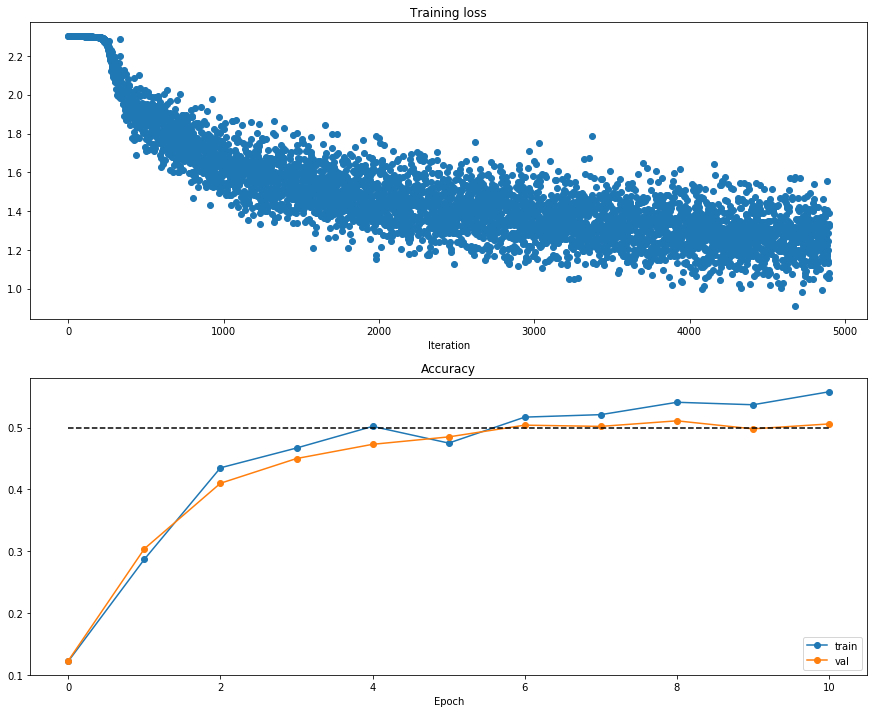

In [23]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

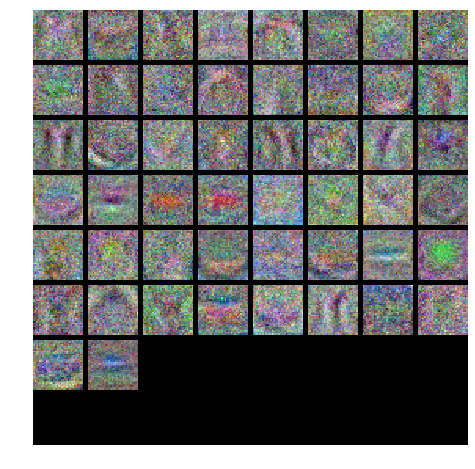

In [24]:
from comp411.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(model)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can (52% could serve as a reference), with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [25]:
best_model = None


#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on thexs previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
input_size = 32 * 32 * 3
num_classes = 10
best_val_acc = -1

hidden_layer_sizes = [100, 150,200]
L2_strengths = [1e-5, 5e-5, 1e-4, 5e-4]

hyperparameters = [(h, l2) for h in hidden_layer_sizes for l2 in L2_strengths]

for epoch in [10, 20]:
    for h, l2 in hyperparameters:
        model = FourLayerNet(input_size, h, num_classes, reg=l2)
        solver = Solver(model, data, num_epochs=epoch, lr_decay=0.95)
        solver.train()
        val_acc = solver.check_accuracy(data['X_val'], data['y_val'])
         
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model
    
    
    
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 4900) loss: 2.301600
(Epoch 0 / 10) train acc: 0.102000; val_acc: 0.087000
(Iteration 11 / 4900) loss: 2.300113
(Iteration 21 / 4900) loss: 2.301105
(Iteration 31 / 4900) loss: 2.299864
(Iteration 41 / 4900) loss: 2.296318
(Iteration 51 / 4900) loss: 2.292690
(Iteration 61 / 4900) loss: 2.288349
(Iteration 71 / 4900) loss: 2.252418
(Iteration 81 / 4900) loss: 2.277566
(Iteration 91 / 4900) loss: 2.223749
(Iteration 101 / 4900) loss: 2.249093
(Iteration 111 / 4900) loss: 2.268970
(Iteration 121 / 4900) loss: 2.228723
(Iteration 131 / 4900) loss: 2.096628
(Iteration 141 / 4900) loss: 2.005643
(Iteration 151 / 4900) loss: 2.112070
(Iteration 161 / 4900) loss: 1.961419
(Iteration 171 / 4900) loss: 2.030060
(Iteration 181 / 4900) loss: 1.923647
(Iteration 191 / 4900) loss: 1.977150
(Iteration 201 / 4900) loss: 1.963021
(Iteration 211 / 4900) loss: 2.061602
(Iteration 221 / 4900) loss: 2.080869
(Iteration 231 / 4900) loss: 1.855135
(Iteration 241 / 4900) loss: 1.793680
(Iterat

(Iteration 2061 / 4900) loss: 1.220881
(Iteration 2071 / 4900) loss: 1.263276
(Iteration 2081 / 4900) loss: 1.257224
(Iteration 2091 / 4900) loss: 1.291242
(Iteration 2101 / 4900) loss: 1.253441
(Iteration 2111 / 4900) loss: 1.407637
(Iteration 2121 / 4900) loss: 1.250359
(Iteration 2131 / 4900) loss: 1.276534
(Iteration 2141 / 4900) loss: 1.336819
(Iteration 2151 / 4900) loss: 1.315010
(Iteration 2161 / 4900) loss: 1.305583
(Iteration 2171 / 4900) loss: 1.299859
(Iteration 2181 / 4900) loss: 1.534173
(Iteration 2191 / 4900) loss: 1.392208
(Iteration 2201 / 4900) loss: 1.148113
(Iteration 2211 / 4900) loss: 1.495509
(Iteration 2221 / 4900) loss: 1.345920
(Iteration 2231 / 4900) loss: 1.370385
(Iteration 2241 / 4900) loss: 1.453155
(Iteration 2251 / 4900) loss: 1.456959
(Iteration 2261 / 4900) loss: 1.322367
(Iteration 2271 / 4900) loss: 1.513060
(Iteration 2281 / 4900) loss: 1.338156
(Iteration 2291 / 4900) loss: 1.415508
(Iteration 2301 / 4900) loss: 1.423617
(Iteration 2311 / 4900) l

(Iteration 4121 / 4900) loss: 0.945869
(Iteration 4131 / 4900) loss: 1.002254
(Iteration 4141 / 4900) loss: 1.147458
(Iteration 4151 / 4900) loss: 1.054262
(Iteration 4161 / 4900) loss: 1.217305
(Iteration 4171 / 4900) loss: 1.001874
(Iteration 4181 / 4900) loss: 1.174263
(Iteration 4191 / 4900) loss: 1.027105
(Iteration 4201 / 4900) loss: 1.116308
(Iteration 4211 / 4900) loss: 0.985943
(Iteration 4221 / 4900) loss: 1.206441
(Iteration 4231 / 4900) loss: 1.241859
(Iteration 4241 / 4900) loss: 1.257443
(Iteration 4251 / 4900) loss: 1.178358
(Iteration 4261 / 4900) loss: 1.181351
(Iteration 4271 / 4900) loss: 1.080438
(Iteration 4281 / 4900) loss: 1.273911
(Iteration 4291 / 4900) loss: 1.078873
(Iteration 4301 / 4900) loss: 1.127731
(Iteration 4311 / 4900) loss: 1.013896
(Iteration 4321 / 4900) loss: 0.962907
(Iteration 4331 / 4900) loss: 1.162693
(Iteration 4341 / 4900) loss: 1.240269
(Iteration 4351 / 4900) loss: 1.249866
(Iteration 4361 / 4900) loss: 1.147241
(Iteration 4371 / 4900) l

(Iteration 1281 / 4900) loss: 1.309477
(Iteration 1291 / 4900) loss: 1.501889
(Iteration 1301 / 4900) loss: 1.318397
(Iteration 1311 / 4900) loss: 1.430479
(Iteration 1321 / 4900) loss: 1.401995
(Iteration 1331 / 4900) loss: 1.519468
(Iteration 1341 / 4900) loss: 1.407798
(Iteration 1351 / 4900) loss: 1.676405
(Iteration 1361 / 4900) loss: 1.502097
(Iteration 1371 / 4900) loss: 1.581235
(Iteration 1381 / 4900) loss: 1.514668
(Iteration 1391 / 4900) loss: 1.512102
(Iteration 1401 / 4900) loss: 1.490382
(Iteration 1411 / 4900) loss: 1.400123
(Iteration 1421 / 4900) loss: 1.584136
(Iteration 1431 / 4900) loss: 1.266671
(Iteration 1441 / 4900) loss: 1.525897
(Iteration 1451 / 4900) loss: 1.427420
(Iteration 1461 / 4900) loss: 1.297469
(Epoch 3 / 10) train acc: 0.473000; val_acc: 0.482000
(Iteration 1471 / 4900) loss: 1.411463
(Iteration 1481 / 4900) loss: 1.495418
(Iteration 1491 / 4900) loss: 1.286033
(Iteration 1501 / 4900) loss: 1.353171
(Iteration 1511 / 4900) loss: 1.547877
(Iteration

(Iteration 3341 / 4900) loss: 0.994904
(Iteration 3351 / 4900) loss: 1.183614
(Iteration 3361 / 4900) loss: 1.160098
(Iteration 3371 / 4900) loss: 1.125008
(Iteration 3381 / 4900) loss: 1.279883
(Iteration 3391 / 4900) loss: 0.995110
(Iteration 3401 / 4900) loss: 1.340276
(Iteration 3411 / 4900) loss: 1.201862
(Iteration 3421 / 4900) loss: 1.297782
(Epoch 7 / 10) train acc: 0.571000; val_acc: 0.511000
(Iteration 3431 / 4900) loss: 1.158614
(Iteration 3441 / 4900) loss: 1.368659
(Iteration 3451 / 4900) loss: 1.258733
(Iteration 3461 / 4900) loss: 1.263248
(Iteration 3471 / 4900) loss: 1.305473
(Iteration 3481 / 4900) loss: 1.372159
(Iteration 3491 / 4900) loss: 1.018442
(Iteration 3501 / 4900) loss: 1.087948
(Iteration 3511 / 4900) loss: 1.125374
(Iteration 3521 / 4900) loss: 1.090498
(Iteration 3531 / 4900) loss: 1.064540
(Iteration 3541 / 4900) loss: 1.213594
(Iteration 3551 / 4900) loss: 1.229737
(Iteration 3561 / 4900) loss: 1.259254
(Iteration 3571 / 4900) loss: 1.321530
(Iteration

(Epoch 1 / 10) train acc: 0.372000; val_acc: 0.388000
(Iteration 491 / 4900) loss: 1.839242
(Iteration 501 / 4900) loss: 1.617660
(Iteration 511 / 4900) loss: 1.619545
(Iteration 521 / 4900) loss: 1.732076
(Iteration 531 / 4900) loss: 1.677093
(Iteration 541 / 4900) loss: 1.947879
(Iteration 551 / 4900) loss: 1.767195
(Iteration 561 / 4900) loss: 1.599814
(Iteration 571 / 4900) loss: 1.627750
(Iteration 581 / 4900) loss: 1.656018
(Iteration 591 / 4900) loss: 1.607071
(Iteration 601 / 4900) loss: 1.660969
(Iteration 611 / 4900) loss: 1.614430
(Iteration 621 / 4900) loss: 1.694568
(Iteration 631 / 4900) loss: 1.566416
(Iteration 641 / 4900) loss: 1.779119
(Iteration 651 / 4900) loss: 1.559767
(Iteration 661 / 4900) loss: 1.560054
(Iteration 671 / 4900) loss: 1.557554
(Iteration 681 / 4900) loss: 1.659616
(Iteration 691 / 4900) loss: 1.581235
(Iteration 701 / 4900) loss: 1.544921
(Iteration 711 / 4900) loss: 1.560732
(Iteration 721 / 4900) loss: 1.698044
(Iteration 731 / 4900) loss: 1.691

(Iteration 2551 / 4900) loss: 1.254842
(Iteration 2561 / 4900) loss: 1.286679
(Iteration 2571 / 4900) loss: 1.156380
(Iteration 2581 / 4900) loss: 1.349324
(Iteration 2591 / 4900) loss: 1.079585
(Iteration 2601 / 4900) loss: 1.165487
(Iteration 2611 / 4900) loss: 1.292762
(Iteration 2621 / 4900) loss: 1.209382
(Iteration 2631 / 4900) loss: 1.334125
(Iteration 2641 / 4900) loss: 1.195828
(Iteration 2651 / 4900) loss: 1.175984
(Iteration 2661 / 4900) loss: 1.074410
(Iteration 2671 / 4900) loss: 1.261433
(Iteration 2681 / 4900) loss: 1.218339
(Iteration 2691 / 4900) loss: 1.168993
(Iteration 2701 / 4900) loss: 1.325840
(Iteration 2711 / 4900) loss: 1.555596
(Iteration 2721 / 4900) loss: 1.401397
(Iteration 2731 / 4900) loss: 1.244672
(Iteration 2741 / 4900) loss: 1.361723
(Iteration 2751 / 4900) loss: 1.197249
(Iteration 2761 / 4900) loss: 1.157688
(Iteration 2771 / 4900) loss: 1.158373
(Iteration 2781 / 4900) loss: 1.162685
(Iteration 2791 / 4900) loss: 1.177433
(Iteration 2801 / 4900) l

(Iteration 4611 / 4900) loss: 1.104422
(Iteration 4621 / 4900) loss: 1.180258
(Iteration 4631 / 4900) loss: 1.304275
(Iteration 4641 / 4900) loss: 1.103132
(Iteration 4651 / 4900) loss: 1.149692
(Iteration 4661 / 4900) loss: 1.183870
(Iteration 4671 / 4900) loss: 1.033287
(Iteration 4681 / 4900) loss: 1.129651
(Iteration 4691 / 4900) loss: 1.012314
(Iteration 4701 / 4900) loss: 1.175228
(Iteration 4711 / 4900) loss: 1.122855
(Iteration 4721 / 4900) loss: 1.048467
(Iteration 4731 / 4900) loss: 1.097791
(Iteration 4741 / 4900) loss: 1.232058
(Iteration 4751 / 4900) loss: 1.012985
(Iteration 4761 / 4900) loss: 0.950236
(Iteration 4771 / 4900) loss: 1.173242
(Iteration 4781 / 4900) loss: 1.128003
(Iteration 4791 / 4900) loss: 1.093652
(Iteration 4801 / 4900) loss: 1.438002
(Iteration 4811 / 4900) loss: 1.099169
(Iteration 4821 / 4900) loss: 1.021156
(Iteration 4831 / 4900) loss: 0.926287
(Iteration 4841 / 4900) loss: 1.000453
(Iteration 4851 / 4900) loss: 1.173129
(Iteration 4861 / 4900) l

(Iteration 1771 / 4900) loss: 1.337099
(Iteration 1781 / 4900) loss: 1.398755
(Iteration 1791 / 4900) loss: 1.350907
(Iteration 1801 / 4900) loss: 1.178805
(Iteration 1811 / 4900) loss: 1.510207
(Iteration 1821 / 4900) loss: 1.475026
(Iteration 1831 / 4900) loss: 1.406455
(Iteration 1841 / 4900) loss: 1.388352
(Iteration 1851 / 4900) loss: 1.330405
(Iteration 1861 / 4900) loss: 1.258604
(Iteration 1871 / 4900) loss: 1.260034
(Iteration 1881 / 4900) loss: 1.444651
(Iteration 1891 / 4900) loss: 1.492050
(Iteration 1901 / 4900) loss: 1.481031
(Iteration 1911 / 4900) loss: 1.423700
(Iteration 1921 / 4900) loss: 1.348543
(Iteration 1931 / 4900) loss: 1.509521
(Iteration 1941 / 4900) loss: 1.393163
(Iteration 1951 / 4900) loss: 1.339533
(Epoch 4 / 10) train acc: 0.507000; val_acc: 0.494000
(Iteration 1961 / 4900) loss: 1.391082
(Iteration 1971 / 4900) loss: 1.616705
(Iteration 1981 / 4900) loss: 1.451514
(Iteration 1991 / 4900) loss: 1.563419
(Iteration 2001 / 4900) loss: 1.472108
(Iteration

(Iteration 3831 / 4900) loss: 1.167582
(Iteration 3841 / 4900) loss: 1.378617
(Iteration 3851 / 4900) loss: 1.444351
(Iteration 3861 / 4900) loss: 1.235019
(Iteration 3871 / 4900) loss: 1.302850
(Iteration 3881 / 4900) loss: 1.296193
(Iteration 3891 / 4900) loss: 1.240073
(Iteration 3901 / 4900) loss: 1.473649
(Iteration 3911 / 4900) loss: 1.361225
(Epoch 8 / 10) train acc: 0.603000; val_acc: 0.523000
(Iteration 3921 / 4900) loss: 1.001654
(Iteration 3931 / 4900) loss: 1.196089
(Iteration 3941 / 4900) loss: 1.261375
(Iteration 3951 / 4900) loss: 1.184426
(Iteration 3961 / 4900) loss: 1.235207
(Iteration 3971 / 4900) loss: 1.098309
(Iteration 3981 / 4900) loss: 1.197459
(Iteration 3991 / 4900) loss: 1.027195
(Iteration 4001 / 4900) loss: 1.205662
(Iteration 4011 / 4900) loss: 0.985716
(Iteration 4021 / 4900) loss: 1.022139
(Iteration 4031 / 4900) loss: 0.996701
(Iteration 4041 / 4900) loss: 1.292787
(Iteration 4051 / 4900) loss: 1.059231
(Iteration 4061 / 4900) loss: 1.220532
(Iteration

(Iteration 1001 / 4900) loss: 1.266695
(Iteration 1011 / 4900) loss: 1.569129
(Iteration 1021 / 4900) loss: 1.505472
(Iteration 1031 / 4900) loss: 1.435624
(Iteration 1041 / 4900) loss: 1.428919
(Iteration 1051 / 4900) loss: 1.490311
(Iteration 1061 / 4900) loss: 1.406920
(Iteration 1071 / 4900) loss: 1.452070
(Iteration 1081 / 4900) loss: 1.603284
(Iteration 1091 / 4900) loss: 1.630588
(Iteration 1101 / 4900) loss: 1.323257
(Iteration 1111 / 4900) loss: 1.539070
(Iteration 1121 / 4900) loss: 1.440791
(Iteration 1131 / 4900) loss: 1.423531
(Iteration 1141 / 4900) loss: 1.373403
(Iteration 1151 / 4900) loss: 1.470191
(Iteration 1161 / 4900) loss: 1.565152
(Iteration 1171 / 4900) loss: 1.297407
(Iteration 1181 / 4900) loss: 1.514910
(Iteration 1191 / 4900) loss: 1.422965
(Iteration 1201 / 4900) loss: 1.393340
(Iteration 1211 / 4900) loss: 1.189442
(Iteration 1221 / 4900) loss: 1.367952
(Iteration 1231 / 4900) loss: 1.443338
(Iteration 1241 / 4900) loss: 1.434145
(Iteration 1251 / 4900) l

(Iteration 3061 / 4900) loss: 1.036143
(Iteration 3071 / 4900) loss: 1.416503
(Iteration 3081 / 4900) loss: 1.330617
(Iteration 3091 / 4900) loss: 1.102050
(Iteration 3101 / 4900) loss: 1.260757
(Iteration 3111 / 4900) loss: 1.194822
(Iteration 3121 / 4900) loss: 1.200767
(Iteration 3131 / 4900) loss: 1.254815
(Iteration 3141 / 4900) loss: 1.074885
(Iteration 3151 / 4900) loss: 1.128655
(Iteration 3161 / 4900) loss: 1.275232
(Iteration 3171 / 4900) loss: 1.161524
(Iteration 3181 / 4900) loss: 1.088848
(Iteration 3191 / 4900) loss: 1.132423
(Iteration 3201 / 4900) loss: 1.088864
(Iteration 3211 / 4900) loss: 1.166614
(Iteration 3221 / 4900) loss: 1.038543
(Iteration 3231 / 4900) loss: 1.167582
(Iteration 3241 / 4900) loss: 1.319494
(Iteration 3251 / 4900) loss: 1.276374
(Iteration 3261 / 4900) loss: 1.210735
(Iteration 3271 / 4900) loss: 0.958261
(Iteration 3281 / 4900) loss: 1.014801
(Iteration 3291 / 4900) loss: 1.181315
(Iteration 3301 / 4900) loss: 1.194134
(Iteration 3311 / 4900) l

(Iteration 201 / 4900) loss: 1.953971
(Iteration 211 / 4900) loss: 1.892396
(Iteration 221 / 4900) loss: 1.908782
(Iteration 231 / 4900) loss: 1.809769
(Iteration 241 / 4900) loss: 1.651102
(Iteration 251 / 4900) loss: 1.805011
(Iteration 261 / 4900) loss: 1.770020
(Iteration 271 / 4900) loss: 1.764140
(Iteration 281 / 4900) loss: 1.698503
(Iteration 291 / 4900) loss: 1.696460
(Iteration 301 / 4900) loss: 1.687456
(Iteration 311 / 4900) loss: 1.817559
(Iteration 321 / 4900) loss: 1.869457
(Iteration 331 / 4900) loss: 1.820463
(Iteration 341 / 4900) loss: 1.829037
(Iteration 351 / 4900) loss: 1.648250
(Iteration 361 / 4900) loss: 1.883296
(Iteration 371 / 4900) loss: 1.865956
(Iteration 381 / 4900) loss: 1.733021
(Iteration 391 / 4900) loss: 1.606403
(Iteration 401 / 4900) loss: 1.554229
(Iteration 411 / 4900) loss: 1.636163
(Iteration 421 / 4900) loss: 1.632530
(Iteration 431 / 4900) loss: 1.845560
(Iteration 441 / 4900) loss: 1.642794
(Iteration 451 / 4900) loss: 1.751300
(Iteration 4

(Iteration 2271 / 4900) loss: 1.236827
(Iteration 2281 / 4900) loss: 1.214954
(Iteration 2291 / 4900) loss: 1.281301
(Iteration 2301 / 4900) loss: 1.217523
(Iteration 2311 / 4900) loss: 1.250606
(Iteration 2321 / 4900) loss: 1.308843
(Iteration 2331 / 4900) loss: 1.171666
(Iteration 2341 / 4900) loss: 1.258178
(Iteration 2351 / 4900) loss: 1.346029
(Iteration 2361 / 4900) loss: 1.336954
(Iteration 2371 / 4900) loss: 1.280411
(Iteration 2381 / 4900) loss: 1.182415
(Iteration 2391 / 4900) loss: 1.232080
(Iteration 2401 / 4900) loss: 1.329103
(Iteration 2411 / 4900) loss: 1.432623
(Iteration 2421 / 4900) loss: 1.346130
(Iteration 2431 / 4900) loss: 1.125300
(Iteration 2441 / 4900) loss: 1.219929
(Epoch 5 / 10) train acc: 0.564000; val_acc: 0.510000
(Iteration 2451 / 4900) loss: 1.306893
(Iteration 2461 / 4900) loss: 1.219788
(Iteration 2471 / 4900) loss: 1.451108
(Iteration 2481 / 4900) loss: 1.307210
(Iteration 2491 / 4900) loss: 1.197819
(Iteration 2501 / 4900) loss: 1.149717
(Iteration

(Iteration 4321 / 4900) loss: 1.165927
(Iteration 4331 / 4900) loss: 0.925658
(Iteration 4341 / 4900) loss: 0.786994
(Iteration 4351 / 4900) loss: 1.168425
(Iteration 4361 / 4900) loss: 1.056896
(Iteration 4371 / 4900) loss: 1.211582
(Iteration 4381 / 4900) loss: 0.998260
(Iteration 4391 / 4900) loss: 1.117597
(Iteration 4401 / 4900) loss: 0.980539
(Epoch 9 / 10) train acc: 0.633000; val_acc: 0.524000
(Iteration 4411 / 4900) loss: 1.081231
(Iteration 4421 / 4900) loss: 1.010329
(Iteration 4431 / 4900) loss: 1.117106
(Iteration 4441 / 4900) loss: 1.154786
(Iteration 4451 / 4900) loss: 1.169619
(Iteration 4461 / 4900) loss: 0.983754
(Iteration 4471 / 4900) loss: 1.031193
(Iteration 4481 / 4900) loss: 0.947531
(Iteration 4491 / 4900) loss: 1.160692
(Iteration 4501 / 4900) loss: 0.960503
(Iteration 4511 / 4900) loss: 1.150929
(Iteration 4521 / 4900) loss: 0.788374
(Iteration 4531 / 4900) loss: 0.995513
(Iteration 4541 / 4900) loss: 1.037729
(Iteration 4551 / 4900) loss: 1.036136
(Iteration

(Iteration 1491 / 4900) loss: 1.453860
(Iteration 1501 / 4900) loss: 1.618574
(Iteration 1511 / 4900) loss: 1.324799
(Iteration 1521 / 4900) loss: 1.485609
(Iteration 1531 / 4900) loss: 1.442407
(Iteration 1541 / 4900) loss: 1.253816
(Iteration 1551 / 4900) loss: 1.414566
(Iteration 1561 / 4900) loss: 1.594560
(Iteration 1571 / 4900) loss: 1.721773
(Iteration 1581 / 4900) loss: 1.322396
(Iteration 1591 / 4900) loss: 1.280362
(Iteration 1601 / 4900) loss: 1.259890
(Iteration 1611 / 4900) loss: 1.544989
(Iteration 1621 / 4900) loss: 1.589250
(Iteration 1631 / 4900) loss: 1.323001
(Iteration 1641 / 4900) loss: 1.430136
(Iteration 1651 / 4900) loss: 1.238050
(Iteration 1661 / 4900) loss: 1.382339
(Iteration 1671 / 4900) loss: 1.503670
(Iteration 1681 / 4900) loss: 1.228943
(Iteration 1691 / 4900) loss: 1.267515
(Iteration 1701 / 4900) loss: 1.562802
(Iteration 1711 / 4900) loss: 1.452780
(Iteration 1721 / 4900) loss: 1.318118
(Iteration 1731 / 4900) loss: 1.229863
(Iteration 1741 / 4900) l

(Iteration 3541 / 4900) loss: 1.143624
(Iteration 3551 / 4900) loss: 1.095522
(Iteration 3561 / 4900) loss: 1.232549
(Iteration 3571 / 4900) loss: 0.988462
(Iteration 3581 / 4900) loss: 1.105314
(Iteration 3591 / 4900) loss: 0.944598
(Iteration 3601 / 4900) loss: 1.296810
(Iteration 3611 / 4900) loss: 1.145971
(Iteration 3621 / 4900) loss: 0.970052
(Iteration 3631 / 4900) loss: 1.127481
(Iteration 3641 / 4900) loss: 0.987062
(Iteration 3651 / 4900) loss: 1.204516
(Iteration 3661 / 4900) loss: 1.122247
(Iteration 3671 / 4900) loss: 1.166744
(Iteration 3681 / 4900) loss: 1.179361
(Iteration 3691 / 4900) loss: 1.270335
(Iteration 3701 / 4900) loss: 1.076813
(Iteration 3711 / 4900) loss: 1.428930
(Iteration 3721 / 4900) loss: 1.050619
(Iteration 3731 / 4900) loss: 1.066881
(Iteration 3741 / 4900) loss: 1.197855
(Iteration 3751 / 4900) loss: 0.982167
(Iteration 3761 / 4900) loss: 1.091615
(Iteration 3771 / 4900) loss: 1.373659
(Iteration 3781 / 4900) loss: 0.981114
(Iteration 3791 / 4900) l

(Iteration 701 / 4900) loss: 1.636333
(Iteration 711 / 4900) loss: 1.610667
(Iteration 721 / 4900) loss: 1.503245
(Iteration 731 / 4900) loss: 1.663579
(Iteration 741 / 4900) loss: 1.581798
(Iteration 751 / 4900) loss: 1.746987
(Iteration 761 / 4900) loss: 1.749297
(Iteration 771 / 4900) loss: 1.568443
(Iteration 781 / 4900) loss: 1.581795
(Iteration 791 / 4900) loss: 2.010638
(Iteration 801 / 4900) loss: 1.719255
(Iteration 811 / 4900) loss: 1.611404
(Iteration 821 / 4900) loss: 1.560018
(Iteration 831 / 4900) loss: 1.566720
(Iteration 841 / 4900) loss: 1.392183
(Iteration 851 / 4900) loss: 1.640106
(Iteration 861 / 4900) loss: 1.570184
(Iteration 871 / 4900) loss: 1.491452
(Iteration 881 / 4900) loss: 1.683023
(Iteration 891 / 4900) loss: 1.523157
(Iteration 901 / 4900) loss: 1.417579
(Iteration 911 / 4900) loss: 1.499330
(Iteration 921 / 4900) loss: 1.369266
(Iteration 931 / 4900) loss: 1.491070
(Iteration 941 / 4900) loss: 1.745305
(Iteration 951 / 4900) loss: 1.417252
(Iteration 9

(Iteration 2771 / 4900) loss: 1.231531
(Iteration 2781 / 4900) loss: 1.668687
(Iteration 2791 / 4900) loss: 1.208549
(Iteration 2801 / 4900) loss: 1.191286
(Iteration 2811 / 4900) loss: 1.445265
(Iteration 2821 / 4900) loss: 1.007202
(Iteration 2831 / 4900) loss: 1.150842
(Iteration 2841 / 4900) loss: 1.132945
(Iteration 2851 / 4900) loss: 1.500188
(Iteration 2861 / 4900) loss: 1.230896
(Iteration 2871 / 4900) loss: 1.274041
(Iteration 2881 / 4900) loss: 1.201183
(Iteration 2891 / 4900) loss: 1.225682
(Iteration 2901 / 4900) loss: 1.231536
(Iteration 2911 / 4900) loss: 1.325260
(Iteration 2921 / 4900) loss: 1.342336
(Iteration 2931 / 4900) loss: 1.208426
(Epoch 6 / 10) train acc: 0.579000; val_acc: 0.523000
(Iteration 2941 / 4900) loss: 1.450438
(Iteration 2951 / 4900) loss: 1.148450
(Iteration 2961 / 4900) loss: 1.288062
(Iteration 2971 / 4900) loss: 1.315239
(Iteration 2981 / 4900) loss: 1.312772
(Iteration 2991 / 4900) loss: 1.046693
(Iteration 3001 / 4900) loss: 1.025934
(Iteration

(Iteration 4831 / 4900) loss: 1.082257
(Iteration 4841 / 4900) loss: 0.896845
(Iteration 4851 / 4900) loss: 0.984768
(Iteration 4861 / 4900) loss: 0.967120
(Iteration 4871 / 4900) loss: 1.152133
(Iteration 4881 / 4900) loss: 1.138727
(Iteration 4891 / 4900) loss: 1.061937
(Epoch 10 / 10) train acc: 0.655000; val_acc: 0.526000
(Iteration 1 / 4900) loss: 2.302294
(Epoch 0 / 10) train acc: 0.091000; val_acc: 0.116000
(Iteration 11 / 4900) loss: 2.298716
(Iteration 21 / 4900) loss: 2.275051
(Iteration 31 / 4900) loss: 2.259118
(Iteration 41 / 4900) loss: 2.212811
(Iteration 51 / 4900) loss: 2.175760
(Iteration 61 / 4900) loss: 2.115934
(Iteration 71 / 4900) loss: 1.985442
(Iteration 81 / 4900) loss: 2.078234
(Iteration 91 / 4900) loss: 1.908176
(Iteration 101 / 4900) loss: 1.969461
(Iteration 111 / 4900) loss: 1.894534
(Iteration 121 / 4900) loss: 1.989096
(Iteration 131 / 4900) loss: 1.912792
(Iteration 141 / 4900) loss: 2.018003
(Iteration 151 / 4900) loss: 1.738004
(Iteration 161 / 4900

(Iteration 1981 / 4900) loss: 1.294662
(Iteration 1991 / 4900) loss: 1.384643
(Iteration 2001 / 4900) loss: 1.347781
(Iteration 2011 / 4900) loss: 1.158558
(Iteration 2021 / 4900) loss: 1.163404
(Iteration 2031 / 4900) loss: 1.385398
(Iteration 2041 / 4900) loss: 1.198647
(Iteration 2051 / 4900) loss: 1.028350
(Iteration 2061 / 4900) loss: 1.126830
(Iteration 2071 / 4900) loss: 1.403966
(Iteration 2081 / 4900) loss: 1.203036
(Iteration 2091 / 4900) loss: 1.037718
(Iteration 2101 / 4900) loss: 1.272822
(Iteration 2111 / 4900) loss: 1.128985
(Iteration 2121 / 4900) loss: 1.117761
(Iteration 2131 / 4900) loss: 1.225151
(Iteration 2141 / 4900) loss: 1.283055
(Iteration 2151 / 4900) loss: 1.404669
(Iteration 2161 / 4900) loss: 1.131878
(Iteration 2171 / 4900) loss: 1.409447
(Iteration 2181 / 4900) loss: 1.274168
(Iteration 2191 / 4900) loss: 0.957228
(Iteration 2201 / 4900) loss: 0.973826
(Iteration 2211 / 4900) loss: 1.292073
(Iteration 2221 / 4900) loss: 1.368480
(Iteration 2231 / 4900) l

(Iteration 4031 / 4900) loss: 1.060721
(Iteration 4041 / 4900) loss: 0.971976
(Iteration 4051 / 4900) loss: 1.059908
(Iteration 4061 / 4900) loss: 0.953432
(Iteration 4071 / 4900) loss: 0.808292
(Iteration 4081 / 4900) loss: 0.906708
(Iteration 4091 / 4900) loss: 1.126253
(Iteration 4101 / 4900) loss: 0.956087
(Iteration 4111 / 4900) loss: 0.900324
(Iteration 4121 / 4900) loss: 1.156679
(Iteration 4131 / 4900) loss: 0.981227
(Iteration 4141 / 4900) loss: 1.182782
(Iteration 4151 / 4900) loss: 1.113845
(Iteration 4161 / 4900) loss: 1.001099
(Iteration 4171 / 4900) loss: 0.883470
(Iteration 4181 / 4900) loss: 1.072455
(Iteration 4191 / 4900) loss: 0.996502
(Iteration 4201 / 4900) loss: 1.043934
(Iteration 4211 / 4900) loss: 1.199697
(Iteration 4221 / 4900) loss: 1.150932
(Iteration 4231 / 4900) loss: 1.041174
(Iteration 4241 / 4900) loss: 1.159836
(Iteration 4251 / 4900) loss: 1.038877
(Iteration 4261 / 4900) loss: 1.010927
(Iteration 4271 / 4900) loss: 1.255013
(Iteration 4281 / 4900) l

(Iteration 1191 / 4900) loss: 1.577184
(Iteration 1201 / 4900) loss: 1.391343
(Iteration 1211 / 4900) loss: 1.439894
(Iteration 1221 / 4900) loss: 1.470381
(Iteration 1231 / 4900) loss: 1.308477
(Iteration 1241 / 4900) loss: 1.211065
(Iteration 1251 / 4900) loss: 1.288587
(Iteration 1261 / 4900) loss: 1.366899
(Iteration 1271 / 4900) loss: 1.398333
(Iteration 1281 / 4900) loss: 1.386044
(Iteration 1291 / 4900) loss: 1.234694
(Iteration 1301 / 4900) loss: 1.440664
(Iteration 1311 / 4900) loss: 1.276004
(Iteration 1321 / 4900) loss: 1.259600
(Iteration 1331 / 4900) loss: 1.272006
(Iteration 1341 / 4900) loss: 1.232152
(Iteration 1351 / 4900) loss: 1.570660
(Iteration 1361 / 4900) loss: 1.485150
(Iteration 1371 / 4900) loss: 1.520970
(Iteration 1381 / 4900) loss: 1.428582
(Iteration 1391 / 4900) loss: 1.468313
(Iteration 1401 / 4900) loss: 1.321928
(Iteration 1411 / 4900) loss: 1.299137
(Iteration 1421 / 4900) loss: 1.210300
(Iteration 1431 / 4900) loss: 1.210739
(Iteration 1441 / 4900) l

(Iteration 3241 / 4900) loss: 1.042618
(Iteration 3251 / 4900) loss: 0.969928
(Iteration 3261 / 4900) loss: 1.111465
(Iteration 3271 / 4900) loss: 1.027047
(Iteration 3281 / 4900) loss: 0.964239
(Iteration 3291 / 4900) loss: 1.093666
(Iteration 3301 / 4900) loss: 1.044086
(Iteration 3311 / 4900) loss: 1.152567
(Iteration 3321 / 4900) loss: 0.978199
(Iteration 3331 / 4900) loss: 1.017626
(Iteration 3341 / 4900) loss: 1.308264
(Iteration 3351 / 4900) loss: 1.190316
(Iteration 3361 / 4900) loss: 1.142580
(Iteration 3371 / 4900) loss: 0.967046
(Iteration 3381 / 4900) loss: 1.487651
(Iteration 3391 / 4900) loss: 1.138261
(Iteration 3401 / 4900) loss: 0.887192
(Iteration 3411 / 4900) loss: 1.092893
(Iteration 3421 / 4900) loss: 1.134539
(Epoch 7 / 10) train acc: 0.611000; val_acc: 0.519000
(Iteration 3431 / 4900) loss: 0.991688
(Iteration 3441 / 4900) loss: 1.094966
(Iteration 3451 / 4900) loss: 1.196931
(Iteration 3461 / 4900) loss: 1.095406
(Iteration 3471 / 4900) loss: 1.221368
(Iteration

(Iteration 391 / 4900) loss: 1.636471
(Iteration 401 / 4900) loss: 1.585018
(Iteration 411 / 4900) loss: 1.389050
(Iteration 421 / 4900) loss: 1.515023
(Iteration 431 / 4900) loss: 1.640206
(Iteration 441 / 4900) loss: 1.669278
(Iteration 451 / 4900) loss: 1.584960
(Iteration 461 / 4900) loss: 1.520841
(Iteration 471 / 4900) loss: 1.487524
(Iteration 481 / 4900) loss: 1.678921
(Epoch 1 / 10) train acc: 0.438000; val_acc: 0.439000
(Iteration 491 / 4900) loss: 1.518925
(Iteration 501 / 4900) loss: 1.801815
(Iteration 511 / 4900) loss: 1.727205
(Iteration 521 / 4900) loss: 1.572618
(Iteration 531 / 4900) loss: 1.681080
(Iteration 541 / 4900) loss: 1.577558
(Iteration 551 / 4900) loss: 1.639210
(Iteration 561 / 4900) loss: 1.726087
(Iteration 571 / 4900) loss: 1.586845
(Iteration 581 / 4900) loss: 1.627064
(Iteration 591 / 4900) loss: 1.537624
(Iteration 601 / 4900) loss: 1.678779
(Iteration 611 / 4900) loss: 1.656546
(Iteration 621 / 4900) loss: 1.350895
(Iteration 631 / 4900) loss: 1.538

(Iteration 2461 / 4900) loss: 1.164052
(Iteration 2471 / 4900) loss: 1.224892
(Iteration 2481 / 4900) loss: 1.191685
(Iteration 2491 / 4900) loss: 1.044513
(Iteration 2501 / 4900) loss: 1.313976
(Iteration 2511 / 4900) loss: 1.264197
(Iteration 2521 / 4900) loss: 1.274758
(Iteration 2531 / 4900) loss: 1.160279
(Iteration 2541 / 4900) loss: 1.323582
(Iteration 2551 / 4900) loss: 1.174918
(Iteration 2561 / 4900) loss: 1.323901
(Iteration 2571 / 4900) loss: 1.348843
(Iteration 2581 / 4900) loss: 1.175338
(Iteration 2591 / 4900) loss: 1.330002
(Iteration 2601 / 4900) loss: 1.161162
(Iteration 2611 / 4900) loss: 1.240307
(Iteration 2621 / 4900) loss: 1.075397
(Iteration 2631 / 4900) loss: 1.110161
(Iteration 2641 / 4900) loss: 1.215571
(Iteration 2651 / 4900) loss: 1.233382
(Iteration 2661 / 4900) loss: 1.009653
(Iteration 2671 / 4900) loss: 0.994570
(Iteration 2681 / 4900) loss: 1.175324
(Iteration 2691 / 4900) loss: 0.988203
(Iteration 2701 / 4900) loss: 1.165983
(Iteration 2711 / 4900) l

(Iteration 4511 / 4900) loss: 0.879335
(Iteration 4521 / 4900) loss: 0.942591
(Iteration 4531 / 4900) loss: 1.062739
(Iteration 4541 / 4900) loss: 0.838936
(Iteration 4551 / 4900) loss: 1.097311
(Iteration 4561 / 4900) loss: 0.803083
(Iteration 4571 / 4900) loss: 0.815427
(Iteration 4581 / 4900) loss: 1.003364
(Iteration 4591 / 4900) loss: 0.918481
(Iteration 4601 / 4900) loss: 0.849348
(Iteration 4611 / 4900) loss: 0.833317
(Iteration 4621 / 4900) loss: 0.974163
(Iteration 4631 / 4900) loss: 0.957441
(Iteration 4641 / 4900) loss: 0.971934
(Iteration 4651 / 4900) loss: 1.132115
(Iteration 4661 / 4900) loss: 1.135086
(Iteration 4671 / 4900) loss: 0.922650
(Iteration 4681 / 4900) loss: 0.927370
(Iteration 4691 / 4900) loss: 1.037698
(Iteration 4701 / 4900) loss: 1.061662
(Iteration 4711 / 4900) loss: 1.069216
(Iteration 4721 / 4900) loss: 0.693756
(Iteration 4731 / 4900) loss: 0.851538
(Iteration 4741 / 4900) loss: 0.743250
(Iteration 4751 / 4900) loss: 0.815010
(Iteration 4761 / 4900) l

(Iteration 1671 / 4900) loss: 1.356743
(Iteration 1681 / 4900) loss: 1.471972
(Iteration 1691 / 4900) loss: 1.580375
(Iteration 1701 / 4900) loss: 1.410219
(Iteration 1711 / 4900) loss: 1.310902
(Iteration 1721 / 4900) loss: 1.528350
(Iteration 1731 / 4900) loss: 1.323452
(Iteration 1741 / 4900) loss: 1.264180
(Iteration 1751 / 4900) loss: 1.167203
(Iteration 1761 / 4900) loss: 1.406249
(Iteration 1771 / 4900) loss: 1.536450
(Iteration 1781 / 4900) loss: 1.387740
(Iteration 1791 / 4900) loss: 1.373042
(Iteration 1801 / 4900) loss: 1.378837
(Iteration 1811 / 4900) loss: 1.413043
(Iteration 1821 / 4900) loss: 1.359833
(Iteration 1831 / 4900) loss: 1.375476
(Iteration 1841 / 4900) loss: 1.487054
(Iteration 1851 / 4900) loss: 1.304269
(Iteration 1861 / 4900) loss: 1.141710
(Iteration 1871 / 4900) loss: 1.357679
(Iteration 1881 / 4900) loss: 1.452792
(Iteration 1891 / 4900) loss: 1.261041
(Iteration 1901 / 4900) loss: 1.512504
(Iteration 1911 / 4900) loss: 1.316460
(Iteration 1921 / 4900) l

(Iteration 3721 / 4900) loss: 1.063770
(Iteration 3731 / 4900) loss: 1.063417
(Iteration 3741 / 4900) loss: 1.217395
(Iteration 3751 / 4900) loss: 1.111441
(Iteration 3761 / 4900) loss: 0.940074
(Iteration 3771 / 4900) loss: 0.905666
(Iteration 3781 / 4900) loss: 1.077691
(Iteration 3791 / 4900) loss: 1.070010
(Iteration 3801 / 4900) loss: 1.134788
(Iteration 3811 / 4900) loss: 1.109729
(Iteration 3821 / 4900) loss: 1.051160
(Iteration 3831 / 4900) loss: 1.152044
(Iteration 3841 / 4900) loss: 1.233715
(Iteration 3851 / 4900) loss: 1.262616
(Iteration 3861 / 4900) loss: 1.207353
(Iteration 3871 / 4900) loss: 1.223372
(Iteration 3881 / 4900) loss: 1.042739
(Iteration 3891 / 4900) loss: 1.022406
(Iteration 3901 / 4900) loss: 1.059114
(Iteration 3911 / 4900) loss: 0.998004
(Epoch 8 / 10) train acc: 0.652000; val_acc: 0.536000
(Iteration 3921 / 4900) loss: 1.167141
(Iteration 3931 / 4900) loss: 1.036628
(Iteration 3941 / 4900) loss: 1.225052
(Iteration 3951 / 4900) loss: 1.080865
(Iteration

(Iteration 881 / 9800) loss: 1.713080
(Iteration 891 / 9800) loss: 1.464679
(Iteration 901 / 9800) loss: 1.550129
(Iteration 911 / 9800) loss: 1.580360
(Iteration 921 / 9800) loss: 1.477709
(Iteration 931 / 9800) loss: 1.479691
(Iteration 941 / 9800) loss: 1.469038
(Iteration 951 / 9800) loss: 1.684178
(Iteration 961 / 9800) loss: 1.510721
(Iteration 971 / 9800) loss: 1.451301
(Epoch 2 / 20) train acc: 0.482000; val_acc: 0.456000
(Iteration 981 / 9800) loss: 1.378104
(Iteration 991 / 9800) loss: 1.416748
(Iteration 1001 / 9800) loss: 1.498329
(Iteration 1011 / 9800) loss: 1.466080
(Iteration 1021 / 9800) loss: 1.476251
(Iteration 1031 / 9800) loss: 1.540573
(Iteration 1041 / 9800) loss: 1.570603
(Iteration 1051 / 9800) loss: 1.565749
(Iteration 1061 / 9800) loss: 1.651160
(Iteration 1071 / 9800) loss: 1.426273
(Iteration 1081 / 9800) loss: 1.502919
(Iteration 1091 / 9800) loss: 1.585135
(Iteration 1101 / 9800) loss: 1.445722
(Iteration 1111 / 9800) loss: 1.628789
(Iteration 1121 / 9800

(Iteration 2931 / 9800) loss: 1.261209
(Epoch 6 / 20) train acc: 0.569000; val_acc: 0.487000
(Iteration 2941 / 9800) loss: 1.232637
(Iteration 2951 / 9800) loss: 1.300184
(Iteration 2961 / 9800) loss: 1.381248
(Iteration 2971 / 9800) loss: 1.198559
(Iteration 2981 / 9800) loss: 1.281207
(Iteration 2991 / 9800) loss: 1.250760
(Iteration 3001 / 9800) loss: 1.083778
(Iteration 3011 / 9800) loss: 1.146988
(Iteration 3021 / 9800) loss: 1.389418
(Iteration 3031 / 9800) loss: 1.080765
(Iteration 3041 / 9800) loss: 1.143084
(Iteration 3051 / 9800) loss: 1.261178
(Iteration 3061 / 9800) loss: 1.255993
(Iteration 3071 / 9800) loss: 1.446025
(Iteration 3081 / 9800) loss: 1.206325
(Iteration 3091 / 9800) loss: 1.352022
(Iteration 3101 / 9800) loss: 1.324468
(Iteration 3111 / 9800) loss: 1.205781
(Iteration 3121 / 9800) loss: 1.080853
(Iteration 3131 / 9800) loss: 1.431206
(Iteration 3141 / 9800) loss: 1.199895
(Iteration 3151 / 9800) loss: 1.247364
(Iteration 3161 / 9800) loss: 1.306891
(Iteration

(Iteration 4981 / 9800) loss: 0.986328
(Iteration 4991 / 9800) loss: 0.913978
(Iteration 5001 / 9800) loss: 1.277091
(Iteration 5011 / 9800) loss: 1.008396
(Iteration 5021 / 9800) loss: 0.986314
(Iteration 5031 / 9800) loss: 1.076972
(Iteration 5041 / 9800) loss: 1.022575
(Iteration 5051 / 9800) loss: 1.116974
(Iteration 5061 / 9800) loss: 1.017690
(Iteration 5071 / 9800) loss: 1.075029
(Iteration 5081 / 9800) loss: 1.022003
(Iteration 5091 / 9800) loss: 0.987849
(Iteration 5101 / 9800) loss: 1.092866
(Iteration 5111 / 9800) loss: 1.056121
(Iteration 5121 / 9800) loss: 1.139515
(Iteration 5131 / 9800) loss: 1.084505
(Iteration 5141 / 9800) loss: 1.176694
(Iteration 5151 / 9800) loss: 0.981077
(Iteration 5161 / 9800) loss: 1.268402
(Iteration 5171 / 9800) loss: 1.037134
(Iteration 5181 / 9800) loss: 1.035558
(Iteration 5191 / 9800) loss: 1.090746
(Iteration 5201 / 9800) loss: 0.958283
(Iteration 5211 / 9800) loss: 0.963159
(Iteration 5221 / 9800) loss: 0.954931
(Iteration 5231 / 9800) l

(Iteration 7041 / 9800) loss: 0.758989
(Iteration 7051 / 9800) loss: 0.822338
(Iteration 7061 / 9800) loss: 0.881716
(Iteration 7071 / 9800) loss: 0.961048
(Iteration 7081 / 9800) loss: 0.939249
(Iteration 7091 / 9800) loss: 1.050432
(Iteration 7101 / 9800) loss: 0.897326
(Iteration 7111 / 9800) loss: 1.008497
(Iteration 7121 / 9800) loss: 1.058201
(Iteration 7131 / 9800) loss: 0.988588
(Iteration 7141 / 9800) loss: 0.990369
(Iteration 7151 / 9800) loss: 0.919043
(Iteration 7161 / 9800) loss: 0.982314
(Iteration 7171 / 9800) loss: 1.049293
(Iteration 7181 / 9800) loss: 0.871124
(Iteration 7191 / 9800) loss: 1.022867
(Iteration 7201 / 9800) loss: 0.908448
(Iteration 7211 / 9800) loss: 0.866755
(Iteration 7221 / 9800) loss: 1.051043
(Iteration 7231 / 9800) loss: 1.006017
(Iteration 7241 / 9800) loss: 0.787297
(Iteration 7251 / 9800) loss: 0.886784
(Iteration 7261 / 9800) loss: 0.868207
(Iteration 7271 / 9800) loss: 0.987124
(Iteration 7281 / 9800) loss: 0.948412
(Iteration 7291 / 9800) l

(Iteration 9101 / 9800) loss: 0.839549
(Iteration 9111 / 9800) loss: 0.867633
(Iteration 9121 / 9800) loss: 0.759574
(Iteration 9131 / 9800) loss: 0.750989
(Iteration 9141 / 9800) loss: 0.987448
(Iteration 9151 / 9800) loss: 0.625338
(Iteration 9161 / 9800) loss: 0.826510
(Iteration 9171 / 9800) loss: 0.831045
(Iteration 9181 / 9800) loss: 0.656894
(Iteration 9191 / 9800) loss: 0.751375
(Iteration 9201 / 9800) loss: 0.838854
(Iteration 9211 / 9800) loss: 0.745439
(Iteration 9221 / 9800) loss: 0.829389
(Iteration 9231 / 9800) loss: 0.684017
(Iteration 9241 / 9800) loss: 0.788722
(Iteration 9251 / 9800) loss: 0.709874
(Iteration 9261 / 9800) loss: 0.934061
(Iteration 9271 / 9800) loss: 0.895655
(Iteration 9281 / 9800) loss: 0.863516
(Iteration 9291 / 9800) loss: 0.797717
(Iteration 9301 / 9800) loss: 1.004469
(Epoch 19 / 20) train acc: 0.719000; val_acc: 0.528000
(Iteration 9311 / 9800) loss: 0.960984
(Iteration 9321 / 9800) loss: 0.873956
(Iteration 9331 / 9800) loss: 0.951632
(Iteratio

(Iteration 1361 / 9800) loss: 1.398825
(Iteration 1371 / 9800) loss: 1.418751
(Iteration 1381 / 9800) loss: 1.421942
(Iteration 1391 / 9800) loss: 1.494909
(Iteration 1401 / 9800) loss: 1.647419
(Iteration 1411 / 9800) loss: 1.474096
(Iteration 1421 / 9800) loss: 1.507196
(Iteration 1431 / 9800) loss: 1.429012
(Iteration 1441 / 9800) loss: 1.320835
(Iteration 1451 / 9800) loss: 1.686985
(Iteration 1461 / 9800) loss: 1.333302
(Epoch 3 / 20) train acc: 0.496000; val_acc: 0.482000
(Iteration 1471 / 9800) loss: 1.338162
(Iteration 1481 / 9800) loss: 1.363919
(Iteration 1491 / 9800) loss: 1.532924
(Iteration 1501 / 9800) loss: 1.489553
(Iteration 1511 / 9800) loss: 1.373348
(Iteration 1521 / 9800) loss: 1.490557
(Iteration 1531 / 9800) loss: 1.350738
(Iteration 1541 / 9800) loss: 1.353410
(Iteration 1551 / 9800) loss: 1.623954
(Iteration 1561 / 9800) loss: 1.565205
(Iteration 1571 / 9800) loss: 1.606457
(Iteration 1581 / 9800) loss: 1.379827
(Iteration 1591 / 9800) loss: 1.303610
(Iteration

(Iteration 3421 / 9800) loss: 1.190469
(Epoch 7 / 20) train acc: 0.582000; val_acc: 0.507000
(Iteration 3431 / 9800) loss: 1.076940
(Iteration 3441 / 9800) loss: 1.262901
(Iteration 3451 / 9800) loss: 1.033741
(Iteration 3461 / 9800) loss: 1.070409
(Iteration 3471 / 9800) loss: 1.253529
(Iteration 3481 / 9800) loss: 1.079430
(Iteration 3491 / 9800) loss: 1.258214
(Iteration 3501 / 9800) loss: 1.423541
(Iteration 3511 / 9800) loss: 1.053438
(Iteration 3521 / 9800) loss: 1.303960
(Iteration 3531 / 9800) loss: 1.048295
(Iteration 3541 / 9800) loss: 1.100951
(Iteration 3551 / 9800) loss: 1.098449
(Iteration 3561 / 9800) loss: 1.254031
(Iteration 3571 / 9800) loss: 1.336635
(Iteration 3581 / 9800) loss: 1.171783
(Iteration 3591 / 9800) loss: 1.187189
(Iteration 3601 / 9800) loss: 1.468675
(Iteration 3611 / 9800) loss: 1.190770
(Iteration 3621 / 9800) loss: 1.364312
(Iteration 3631 / 9800) loss: 1.125238
(Iteration 3641 / 9800) loss: 1.266706
(Iteration 3651 / 9800) loss: 1.273750
(Iteration

(Iteration 5471 / 9800) loss: 0.983088
(Iteration 5481 / 9800) loss: 0.985129
(Iteration 5491 / 9800) loss: 1.086469
(Iteration 5501 / 9800) loss: 1.022885
(Iteration 5511 / 9800) loss: 0.983603
(Iteration 5521 / 9800) loss: 1.317857
(Iteration 5531 / 9800) loss: 1.076219
(Iteration 5541 / 9800) loss: 0.946622
(Iteration 5551 / 9800) loss: 1.087461
(Iteration 5561 / 9800) loss: 0.953625
(Iteration 5571 / 9800) loss: 1.077158
(Iteration 5581 / 9800) loss: 1.089734
(Iteration 5591 / 9800) loss: 0.946797
(Iteration 5601 / 9800) loss: 1.017088
(Iteration 5611 / 9800) loss: 1.036608
(Iteration 5621 / 9800) loss: 0.891267
(Iteration 5631 / 9800) loss: 0.913561
(Iteration 5641 / 9800) loss: 1.166764
(Iteration 5651 / 9800) loss: 1.053762
(Iteration 5661 / 9800) loss: 1.056748
(Iteration 5671 / 9800) loss: 0.949462
(Iteration 5681 / 9800) loss: 0.976725
(Iteration 5691 / 9800) loss: 1.060494
(Iteration 5701 / 9800) loss: 1.188722
(Iteration 5711 / 9800) loss: 0.964934
(Iteration 5721 / 9800) l

(Iteration 7531 / 9800) loss: 0.800945
(Iteration 7541 / 9800) loss: 0.999429
(Iteration 7551 / 9800) loss: 0.937017
(Iteration 7561 / 9800) loss: 0.909168
(Iteration 7571 / 9800) loss: 0.927318
(Iteration 7581 / 9800) loss: 1.037088
(Iteration 7591 / 9800) loss: 1.004689
(Iteration 7601 / 9800) loss: 0.887761
(Iteration 7611 / 9800) loss: 0.825464
(Iteration 7621 / 9800) loss: 1.129470
(Iteration 7631 / 9800) loss: 0.957418
(Iteration 7641 / 9800) loss: 0.980285
(Iteration 7651 / 9800) loss: 0.989486
(Iteration 7661 / 9800) loss: 0.804960
(Iteration 7671 / 9800) loss: 0.884728
(Iteration 7681 / 9800) loss: 0.941321
(Iteration 7691 / 9800) loss: 0.939182
(Iteration 7701 / 9800) loss: 1.048276
(Iteration 7711 / 9800) loss: 0.951643
(Iteration 7721 / 9800) loss: 0.847613
(Iteration 7731 / 9800) loss: 1.160836
(Iteration 7741 / 9800) loss: 0.786782
(Iteration 7751 / 9800) loss: 1.078129
(Iteration 7761 / 9800) loss: 0.899329
(Iteration 7771 / 9800) loss: 1.057959
(Iteration 7781 / 9800) l

(Iteration 9591 / 9800) loss: 0.823897
(Iteration 9601 / 9800) loss: 0.901157
(Iteration 9611 / 9800) loss: 0.794357
(Iteration 9621 / 9800) loss: 0.713993
(Iteration 9631 / 9800) loss: 0.792130
(Iteration 9641 / 9800) loss: 0.775854
(Iteration 9651 / 9800) loss: 0.802052
(Iteration 9661 / 9800) loss: 0.786041
(Iteration 9671 / 9800) loss: 0.967513
(Iteration 9681 / 9800) loss: 0.715580
(Iteration 9691 / 9800) loss: 0.725959
(Iteration 9701 / 9800) loss: 0.875575
(Iteration 9711 / 9800) loss: 0.771295
(Iteration 9721 / 9800) loss: 0.556887
(Iteration 9731 / 9800) loss: 0.761792
(Iteration 9741 / 9800) loss: 0.766866
(Iteration 9751 / 9800) loss: 0.754671
(Iteration 9761 / 9800) loss: 0.649435
(Iteration 9771 / 9800) loss: 0.910705
(Iteration 9781 / 9800) loss: 0.998858
(Iteration 9791 / 9800) loss: 0.993200
(Epoch 20 / 20) train acc: 0.699000; val_acc: 0.525000
(Iteration 1 / 9800) loss: 2.306824
(Epoch 0 / 20) train acc: 0.096000; val_acc: 0.080000
(Iteration 11 / 9800) loss: 2.304296

(Iteration 1851 / 9800) loss: 1.387044
(Iteration 1861 / 9800) loss: 1.498744
(Iteration 1871 / 9800) loss: 1.160359
(Iteration 1881 / 9800) loss: 1.351380
(Iteration 1891 / 9800) loss: 1.410002
(Iteration 1901 / 9800) loss: 1.484868
(Iteration 1911 / 9800) loss: 1.385519
(Iteration 1921 / 9800) loss: 1.394955
(Iteration 1931 / 9800) loss: 1.487366
(Iteration 1941 / 9800) loss: 1.323028
(Iteration 1951 / 9800) loss: 1.422081
(Epoch 4 / 20) train acc: 0.515000; val_acc: 0.497000
(Iteration 1961 / 9800) loss: 1.414591
(Iteration 1971 / 9800) loss: 1.370827
(Iteration 1981 / 9800) loss: 1.310738
(Iteration 1991 / 9800) loss: 1.384736
(Iteration 2001 / 9800) loss: 1.395057
(Iteration 2011 / 9800) loss: 1.486787
(Iteration 2021 / 9800) loss: 1.309198
(Iteration 2031 / 9800) loss: 1.427116
(Iteration 2041 / 9800) loss: 1.435308
(Iteration 2051 / 9800) loss: 1.326869
(Iteration 2061 / 9800) loss: 1.315705
(Iteration 2071 / 9800) loss: 1.264283
(Iteration 2081 / 9800) loss: 1.338972
(Iteration

(Iteration 3911 / 9800) loss: 1.207169
(Epoch 8 / 20) train acc: 0.588000; val_acc: 0.514000
(Iteration 3921 / 9800) loss: 1.181141
(Iteration 3931 / 9800) loss: 1.202422
(Iteration 3941 / 9800) loss: 1.223028
(Iteration 3951 / 9800) loss: 0.848966
(Iteration 3961 / 9800) loss: 1.257290
(Iteration 3971 / 9800) loss: 1.185181
(Iteration 3981 / 9800) loss: 1.197936
(Iteration 3991 / 9800) loss: 1.180922
(Iteration 4001 / 9800) loss: 1.271285
(Iteration 4011 / 9800) loss: 1.145557
(Iteration 4021 / 9800) loss: 1.180660
(Iteration 4031 / 9800) loss: 1.216141
(Iteration 4041 / 9800) loss: 1.270662
(Iteration 4051 / 9800) loss: 1.103869
(Iteration 4061 / 9800) loss: 1.110908
(Iteration 4071 / 9800) loss: 1.154966
(Iteration 4081 / 9800) loss: 1.190782
(Iteration 4091 / 9800) loss: 1.062628
(Iteration 4101 / 9800) loss: 1.166671
(Iteration 4111 / 9800) loss: 1.129503
(Iteration 4121 / 9800) loss: 1.004656
(Iteration 4131 / 9800) loss: 0.961796
(Iteration 4141 / 9800) loss: 1.121347
(Iteration

(Iteration 5961 / 9800) loss: 1.089244
(Iteration 5971 / 9800) loss: 1.037012
(Iteration 5981 / 9800) loss: 1.016366
(Iteration 5991 / 9800) loss: 0.988894
(Iteration 6001 / 9800) loss: 1.016144
(Iteration 6011 / 9800) loss: 1.155272
(Iteration 6021 / 9800) loss: 1.030935
(Iteration 6031 / 9800) loss: 1.051995
(Iteration 6041 / 9800) loss: 0.972934
(Iteration 6051 / 9800) loss: 1.142841
(Iteration 6061 / 9800) loss: 1.064942
(Iteration 6071 / 9800) loss: 0.965308
(Iteration 6081 / 9800) loss: 1.086625
(Iteration 6091 / 9800) loss: 1.086256
(Iteration 6101 / 9800) loss: 1.139004
(Iteration 6111 / 9800) loss: 0.795872
(Iteration 6121 / 9800) loss: 0.914223
(Iteration 6131 / 9800) loss: 0.919225
(Iteration 6141 / 9800) loss: 0.998223
(Iteration 6151 / 9800) loss: 1.019124
(Iteration 6161 / 9800) loss: 0.922674
(Iteration 6171 / 9800) loss: 1.050542
(Iteration 6181 / 9800) loss: 0.910930
(Iteration 6191 / 9800) loss: 1.095807
(Iteration 6201 / 9800) loss: 1.000049
(Iteration 6211 / 9800) l

(Iteration 8021 / 9800) loss: 1.062414
(Iteration 8031 / 9800) loss: 0.934318
(Iteration 8041 / 9800) loss: 0.720529
(Iteration 8051 / 9800) loss: 0.740501
(Iteration 8061 / 9800) loss: 0.749208
(Iteration 8071 / 9800) loss: 0.956314
(Iteration 8081 / 9800) loss: 0.954413
(Iteration 8091 / 9800) loss: 1.017329
(Iteration 8101 / 9800) loss: 0.939825
(Iteration 8111 / 9800) loss: 0.776587
(Iteration 8121 / 9800) loss: 0.790032
(Iteration 8131 / 9800) loss: 1.077919
(Iteration 8141 / 9800) loss: 0.997074
(Iteration 8151 / 9800) loss: 1.073143
(Iteration 8161 / 9800) loss: 0.830127
(Iteration 8171 / 9800) loss: 1.024149
(Iteration 8181 / 9800) loss: 0.997599
(Iteration 8191 / 9800) loss: 1.030689
(Iteration 8201 / 9800) loss: 0.725660
(Iteration 8211 / 9800) loss: 0.975750
(Iteration 8221 / 9800) loss: 0.952971
(Iteration 8231 / 9800) loss: 0.904779
(Iteration 8241 / 9800) loss: 1.126774
(Iteration 8251 / 9800) loss: 0.786831
(Iteration 8261 / 9800) loss: 0.883315
(Iteration 8271 / 9800) l

(Iteration 271 / 9800) loss: 1.951212
(Iteration 281 / 9800) loss: 1.848854
(Iteration 291 / 9800) loss: 1.795572
(Iteration 301 / 9800) loss: 1.891054
(Iteration 311 / 9800) loss: 1.835269
(Iteration 321 / 9800) loss: 1.843320
(Iteration 331 / 9800) loss: 1.774023
(Iteration 341 / 9800) loss: 1.975615
(Iteration 351 / 9800) loss: 1.819797
(Iteration 361 / 9800) loss: 1.879121
(Iteration 371 / 9800) loss: 1.982747
(Iteration 381 / 9800) loss: 1.692145
(Iteration 391 / 9800) loss: 1.823143
(Iteration 401 / 9800) loss: 1.769043
(Iteration 411 / 9800) loss: 1.792697
(Iteration 421 / 9800) loss: 1.715171
(Iteration 431 / 9800) loss: 1.790481
(Iteration 441 / 9800) loss: 1.687649
(Iteration 451 / 9800) loss: 1.737869
(Iteration 461 / 9800) loss: 1.700430
(Iteration 471 / 9800) loss: 1.721600
(Iteration 481 / 9800) loss: 1.616445
(Epoch 1 / 20) train acc: 0.369000; val_acc: 0.405000
(Iteration 491 / 9800) loss: 1.721378
(Iteration 501 / 9800) loss: 1.499523
(Iteration 511 / 9800) loss: 1.706

(Iteration 2341 / 9800) loss: 1.343670
(Iteration 2351 / 9800) loss: 1.209315
(Iteration 2361 / 9800) loss: 1.112528
(Iteration 2371 / 9800) loss: 1.435930
(Iteration 2381 / 9800) loss: 1.385743
(Iteration 2391 / 9800) loss: 1.304543
(Iteration 2401 / 9800) loss: 1.326359
(Iteration 2411 / 9800) loss: 1.242859
(Iteration 2421 / 9800) loss: 1.198936
(Iteration 2431 / 9800) loss: 1.212061
(Iteration 2441 / 9800) loss: 1.300168
(Epoch 5 / 20) train acc: 0.573000; val_acc: 0.512000
(Iteration 2451 / 9800) loss: 1.435032
(Iteration 2461 / 9800) loss: 1.509103
(Iteration 2471 / 9800) loss: 1.402162
(Iteration 2481 / 9800) loss: 1.308138
(Iteration 2491 / 9800) loss: 1.451653
(Iteration 2501 / 9800) loss: 1.498166
(Iteration 2511 / 9800) loss: 1.466145
(Iteration 2521 / 9800) loss: 1.114322
(Iteration 2531 / 9800) loss: 1.415798
(Iteration 2541 / 9800) loss: 1.310857
(Iteration 2551 / 9800) loss: 1.276869
(Iteration 2561 / 9800) loss: 1.256799
(Iteration 2571 / 9800) loss: 1.239135
(Iteration

(Iteration 4401 / 9800) loss: 1.268049
(Epoch 9 / 20) train acc: 0.586000; val_acc: 0.528000
(Iteration 4411 / 9800) loss: 1.197574
(Iteration 4421 / 9800) loss: 1.012458
(Iteration 4431 / 9800) loss: 1.203409
(Iteration 4441 / 9800) loss: 1.094474
(Iteration 4451 / 9800) loss: 1.195758
(Iteration 4461 / 9800) loss: 1.051175
(Iteration 4471 / 9800) loss: 1.138039
(Iteration 4481 / 9800) loss: 0.880032
(Iteration 4491 / 9800) loss: 1.166151
(Iteration 4501 / 9800) loss: 1.109089
(Iteration 4511 / 9800) loss: 1.151397
(Iteration 4521 / 9800) loss: 1.243787
(Iteration 4531 / 9800) loss: 1.296635
(Iteration 4541 / 9800) loss: 1.133430
(Iteration 4551 / 9800) loss: 1.096804
(Iteration 4561 / 9800) loss: 1.086367
(Iteration 4571 / 9800) loss: 1.149524
(Iteration 4581 / 9800) loss: 0.992579
(Iteration 4591 / 9800) loss: 1.137160
(Iteration 4601 / 9800) loss: 1.204392
(Iteration 4611 / 9800) loss: 1.207961
(Iteration 4621 / 9800) loss: 0.984184
(Iteration 4631 / 9800) loss: 1.099890
(Iteration

(Iteration 6451 / 9800) loss: 0.852608
(Iteration 6461 / 9800) loss: 1.041141
(Iteration 6471 / 9800) loss: 1.088256
(Iteration 6481 / 9800) loss: 0.946112
(Iteration 6491 / 9800) loss: 0.894745
(Iteration 6501 / 9800) loss: 1.112357
(Iteration 6511 / 9800) loss: 1.084311
(Iteration 6521 / 9800) loss: 0.933430
(Iteration 6531 / 9800) loss: 0.993567
(Iteration 6541 / 9800) loss: 1.109457
(Iteration 6551 / 9800) loss: 0.940111
(Iteration 6561 / 9800) loss: 1.206520
(Iteration 6571 / 9800) loss: 1.019314
(Iteration 6581 / 9800) loss: 1.121521
(Iteration 6591 / 9800) loss: 1.028281
(Iteration 6601 / 9800) loss: 1.195706
(Iteration 6611 / 9800) loss: 1.222235
(Iteration 6621 / 9800) loss: 1.086865
(Iteration 6631 / 9800) loss: 0.982169
(Iteration 6641 / 9800) loss: 0.978034
(Iteration 6651 / 9800) loss: 1.051818
(Iteration 6661 / 9800) loss: 1.022523
(Iteration 6671 / 9800) loss: 0.757939
(Iteration 6681 / 9800) loss: 1.113301
(Iteration 6691 / 9800) loss: 1.021066
(Iteration 6701 / 9800) l

(Iteration 8501 / 9800) loss: 0.888186
(Iteration 8511 / 9800) loss: 0.908182
(Iteration 8521 / 9800) loss: 0.989286
(Iteration 8531 / 9800) loss: 1.225389
(Iteration 8541 / 9800) loss: 0.807785
(Iteration 8551 / 9800) loss: 0.948096
(Iteration 8561 / 9800) loss: 1.135134
(Iteration 8571 / 9800) loss: 0.926658
(Iteration 8581 / 9800) loss: 0.912597
(Iteration 8591 / 9800) loss: 0.874575
(Iteration 8601 / 9800) loss: 0.801459
(Iteration 8611 / 9800) loss: 0.719459
(Iteration 8621 / 9800) loss: 0.722228
(Iteration 8631 / 9800) loss: 0.745475
(Iteration 8641 / 9800) loss: 0.781937
(Iteration 8651 / 9800) loss: 0.795072
(Iteration 8661 / 9800) loss: 1.012573
(Iteration 8671 / 9800) loss: 0.963161
(Iteration 8681 / 9800) loss: 0.911843
(Iteration 8691 / 9800) loss: 1.080677
(Iteration 8701 / 9800) loss: 0.853428
(Iteration 8711 / 9800) loss: 0.982386
(Iteration 8721 / 9800) loss: 1.091357
(Iteration 8731 / 9800) loss: 0.865583
(Iteration 8741 / 9800) loss: 0.799148
(Iteration 8751 / 9800) l

(Iteration 761 / 9800) loss: 1.391149
(Iteration 771 / 9800) loss: 1.413077
(Iteration 781 / 9800) loss: 1.566314
(Iteration 791 / 9800) loss: 1.453793
(Iteration 801 / 9800) loss: 1.484126
(Iteration 811 / 9800) loss: 1.439545
(Iteration 821 / 9800) loss: 1.666526
(Iteration 831 / 9800) loss: 1.572156
(Iteration 841 / 9800) loss: 1.472168
(Iteration 851 / 9800) loss: 1.522666
(Iteration 861 / 9800) loss: 1.503880
(Iteration 871 / 9800) loss: 1.454418
(Iteration 881 / 9800) loss: 1.538337
(Iteration 891 / 9800) loss: 1.487092
(Iteration 901 / 9800) loss: 1.402931
(Iteration 911 / 9800) loss: 1.426068
(Iteration 921 / 9800) loss: 1.448509
(Iteration 931 / 9800) loss: 1.454733
(Iteration 941 / 9800) loss: 1.469665
(Iteration 951 / 9800) loss: 1.609908
(Iteration 961 / 9800) loss: 1.465576
(Iteration 971 / 9800) loss: 1.441678
(Epoch 2 / 20) train acc: 0.428000; val_acc: 0.464000
(Iteration 981 / 9800) loss: 1.790484
(Iteration 991 / 9800) loss: 1.575905
(Iteration 1001 / 9800) loss: 1.64

(Iteration 2831 / 9800) loss: 1.426738
(Iteration 2841 / 9800) loss: 0.993057
(Iteration 2851 / 9800) loss: 1.384912
(Iteration 2861 / 9800) loss: 1.185235
(Iteration 2871 / 9800) loss: 1.026544
(Iteration 2881 / 9800) loss: 1.095256
(Iteration 2891 / 9800) loss: 1.243587
(Iteration 2901 / 9800) loss: 1.127079
(Iteration 2911 / 9800) loss: 1.177831
(Iteration 2921 / 9800) loss: 1.273527
(Iteration 2931 / 9800) loss: 1.241669
(Epoch 6 / 20) train acc: 0.573000; val_acc: 0.528000
(Iteration 2941 / 9800) loss: 1.359597
(Iteration 2951 / 9800) loss: 1.033911
(Iteration 2961 / 9800) loss: 1.161831
(Iteration 2971 / 9800) loss: 1.076382
(Iteration 2981 / 9800) loss: 1.133749
(Iteration 2991 / 9800) loss: 1.155649
(Iteration 3001 / 9800) loss: 1.286569
(Iteration 3011 / 9800) loss: 1.087338
(Iteration 3021 / 9800) loss: 1.214154
(Iteration 3031 / 9800) loss: 0.975911
(Iteration 3041 / 9800) loss: 0.982799
(Iteration 3051 / 9800) loss: 1.315930
(Iteration 3061 / 9800) loss: 1.206905
(Iteration

(Iteration 4881 / 9800) loss: 1.096892
(Iteration 4891 / 9800) loss: 0.970535
(Epoch 10 / 20) train acc: 0.632000; val_acc: 0.531000
(Iteration 4901 / 9800) loss: 0.901812
(Iteration 4911 / 9800) loss: 1.147358
(Iteration 4921 / 9800) loss: 1.220838
(Iteration 4931 / 9800) loss: 1.125492
(Iteration 4941 / 9800) loss: 1.051825
(Iteration 4951 / 9800) loss: 1.055254
(Iteration 4961 / 9800) loss: 1.003474
(Iteration 4971 / 9800) loss: 1.066313
(Iteration 4981 / 9800) loss: 1.051636
(Iteration 4991 / 9800) loss: 0.800766
(Iteration 5001 / 9800) loss: 0.987585
(Iteration 5011 / 9800) loss: 1.005025
(Iteration 5021 / 9800) loss: 0.881533
(Iteration 5031 / 9800) loss: 1.223808
(Iteration 5041 / 9800) loss: 0.844266
(Iteration 5051 / 9800) loss: 0.960343
(Iteration 5061 / 9800) loss: 1.029345
(Iteration 5071 / 9800) loss: 1.029647
(Iteration 5081 / 9800) loss: 0.953036
(Iteration 5091 / 9800) loss: 1.125231
(Iteration 5101 / 9800) loss: 0.816203
(Iteration 5111 / 9800) loss: 1.020368
(Iteratio

(Iteration 6921 / 9800) loss: 1.000189
(Iteration 6931 / 9800) loss: 0.872990
(Iteration 6941 / 9800) loss: 0.949875
(Iteration 6951 / 9800) loss: 0.785891
(Iteration 6961 / 9800) loss: 0.697341
(Iteration 6971 / 9800) loss: 0.814378
(Iteration 6981 / 9800) loss: 0.726264
(Iteration 6991 / 9800) loss: 0.714076
(Iteration 7001 / 9800) loss: 1.074239
(Iteration 7011 / 9800) loss: 0.928055
(Iteration 7021 / 9800) loss: 0.752385
(Iteration 7031 / 9800) loss: 0.830953
(Iteration 7041 / 9800) loss: 0.844273
(Iteration 7051 / 9800) loss: 0.711473
(Iteration 7061 / 9800) loss: 0.751309
(Iteration 7071 / 9800) loss: 0.746812
(Iteration 7081 / 9800) loss: 0.847228
(Iteration 7091 / 9800) loss: 0.619525
(Iteration 7101 / 9800) loss: 0.627887
(Iteration 7111 / 9800) loss: 0.714852
(Iteration 7121 / 9800) loss: 0.861172
(Iteration 7131 / 9800) loss: 0.718865
(Iteration 7141 / 9800) loss: 0.704433
(Iteration 7151 / 9800) loss: 0.745743
(Iteration 7161 / 9800) loss: 1.077930
(Iteration 7171 / 9800) l

(Iteration 8981 / 9800) loss: 0.744571
(Iteration 8991 / 9800) loss: 0.758763
(Iteration 9001 / 9800) loss: 0.776032
(Iteration 9011 / 9800) loss: 0.536634
(Iteration 9021 / 9800) loss: 0.779763
(Iteration 9031 / 9800) loss: 0.696599
(Iteration 9041 / 9800) loss: 0.766093
(Iteration 9051 / 9800) loss: 0.740118
(Iteration 9061 / 9800) loss: 0.520410
(Iteration 9071 / 9800) loss: 0.547861
(Iteration 9081 / 9800) loss: 0.662404
(Iteration 9091 / 9800) loss: 0.670019
(Iteration 9101 / 9800) loss: 0.756154
(Iteration 9111 / 9800) loss: 0.549438
(Iteration 9121 / 9800) loss: 0.612151
(Iteration 9131 / 9800) loss: 0.795094
(Iteration 9141 / 9800) loss: 0.701083
(Iteration 9151 / 9800) loss: 0.713302
(Iteration 9161 / 9800) loss: 0.670025
(Iteration 9171 / 9800) loss: 0.730080
(Iteration 9181 / 9800) loss: 0.725745
(Iteration 9191 / 9800) loss: 0.640443
(Iteration 9201 / 9800) loss: 0.799376
(Iteration 9211 / 9800) loss: 0.820423
(Iteration 9221 / 9800) loss: 0.686312
(Iteration 9231 / 9800) l

(Iteration 1241 / 9800) loss: 1.575376
(Iteration 1251 / 9800) loss: 1.138162
(Iteration 1261 / 9800) loss: 1.445059
(Iteration 1271 / 9800) loss: 1.258354
(Iteration 1281 / 9800) loss: 1.332216
(Iteration 1291 / 9800) loss: 1.428228
(Iteration 1301 / 9800) loss: 1.393721
(Iteration 1311 / 9800) loss: 1.271259
(Iteration 1321 / 9800) loss: 1.230361
(Iteration 1331 / 9800) loss: 1.408038
(Iteration 1341 / 9800) loss: 1.376369
(Iteration 1351 / 9800) loss: 1.411825
(Iteration 1361 / 9800) loss: 1.506153
(Iteration 1371 / 9800) loss: 1.484743
(Iteration 1381 / 9800) loss: 1.378521
(Iteration 1391 / 9800) loss: 1.345144
(Iteration 1401 / 9800) loss: 1.227460
(Iteration 1411 / 9800) loss: 1.470831
(Iteration 1421 / 9800) loss: 1.481304
(Iteration 1431 / 9800) loss: 1.322056
(Iteration 1441 / 9800) loss: 1.336835
(Iteration 1451 / 9800) loss: 1.264263
(Iteration 1461 / 9800) loss: 1.283723
(Epoch 3 / 20) train acc: 0.511000; val_acc: 0.493000
(Iteration 1471 / 9800) loss: 1.609739
(Iteration

(Iteration 3291 / 9800) loss: 1.111529
(Iteration 3301 / 9800) loss: 1.202947
(Iteration 3311 / 9800) loss: 1.121994
(Iteration 3321 / 9800) loss: 1.011290
(Iteration 3331 / 9800) loss: 1.045938
(Iteration 3341 / 9800) loss: 1.051099
(Iteration 3351 / 9800) loss: 1.152388
(Iteration 3361 / 9800) loss: 1.304076
(Iteration 3371 / 9800) loss: 1.073150
(Iteration 3381 / 9800) loss: 1.221731
(Iteration 3391 / 9800) loss: 1.145344
(Iteration 3401 / 9800) loss: 1.279564
(Iteration 3411 / 9800) loss: 1.220025
(Iteration 3421 / 9800) loss: 1.235946
(Epoch 7 / 20) train acc: 0.594000; val_acc: 0.523000
(Iteration 3431 / 9800) loss: 1.041399
(Iteration 3441 / 9800) loss: 1.162264
(Iteration 3451 / 9800) loss: 1.078840
(Iteration 3461 / 9800) loss: 1.202373
(Iteration 3471 / 9800) loss: 1.152251
(Iteration 3481 / 9800) loss: 1.286043
(Iteration 3491 / 9800) loss: 1.273417
(Iteration 3501 / 9800) loss: 1.264868
(Iteration 3511 / 9800) loss: 1.027515
(Iteration 3521 / 9800) loss: 1.216200
(Iteration

(Iteration 5341 / 9800) loss: 0.903982
(Iteration 5351 / 9800) loss: 1.085560
(Iteration 5361 / 9800) loss: 0.783249
(Iteration 5371 / 9800) loss: 1.081858
(Iteration 5381 / 9800) loss: 0.994122
(Epoch 11 / 20) train acc: 0.687000; val_acc: 0.549000
(Iteration 5391 / 9800) loss: 0.883830
(Iteration 5401 / 9800) loss: 0.954639
(Iteration 5411 / 9800) loss: 0.997930
(Iteration 5421 / 9800) loss: 0.864636
(Iteration 5431 / 9800) loss: 1.051622
(Iteration 5441 / 9800) loss: 1.189444
(Iteration 5451 / 9800) loss: 0.918987
(Iteration 5461 / 9800) loss: 0.786342
(Iteration 5471 / 9800) loss: 0.886295
(Iteration 5481 / 9800) loss: 1.033133
(Iteration 5491 / 9800) loss: 0.775206
(Iteration 5501 / 9800) loss: 0.888224
(Iteration 5511 / 9800) loss: 0.985425
(Iteration 5521 / 9800) loss: 0.775351
(Iteration 5531 / 9800) loss: 0.836086
(Iteration 5541 / 9800) loss: 0.879860
(Iteration 5551 / 9800) loss: 0.906674
(Iteration 5561 / 9800) loss: 0.906930
(Iteration 5571 / 9800) loss: 0.857075
(Iteratio

(Iteration 7381 / 9800) loss: 1.081835
(Iteration 7391 / 9800) loss: 0.662717
(Iteration 7401 / 9800) loss: 0.939969
(Iteration 7411 / 9800) loss: 0.950258
(Iteration 7421 / 9800) loss: 0.899213
(Iteration 7431 / 9800) loss: 0.734850
(Iteration 7441 / 9800) loss: 0.871054
(Iteration 7451 / 9800) loss: 0.928084
(Iteration 7461 / 9800) loss: 0.928686
(Iteration 7471 / 9800) loss: 0.810010
(Iteration 7481 / 9800) loss: 0.794185
(Iteration 7491 / 9800) loss: 0.930929
(Iteration 7501 / 9800) loss: 0.750452
(Iteration 7511 / 9800) loss: 0.929384
(Iteration 7521 / 9800) loss: 0.796360
(Iteration 7531 / 9800) loss: 0.826053
(Iteration 7541 / 9800) loss: 0.677078
(Iteration 7551 / 9800) loss: 0.701317
(Iteration 7561 / 9800) loss: 0.702215
(Iteration 7571 / 9800) loss: 0.777636
(Iteration 7581 / 9800) loss: 0.780250
(Iteration 7591 / 9800) loss: 0.596218
(Iteration 7601 / 9800) loss: 0.950252
(Iteration 7611 / 9800) loss: 0.984160
(Iteration 7621 / 9800) loss: 0.668907
(Iteration 7631 / 9800) l

(Iteration 9441 / 9800) loss: 0.739276
(Iteration 9451 / 9800) loss: 0.744130
(Iteration 9461 / 9800) loss: 0.809005
(Iteration 9471 / 9800) loss: 0.680307
(Iteration 9481 / 9800) loss: 0.700820
(Iteration 9491 / 9800) loss: 0.689268
(Iteration 9501 / 9800) loss: 0.665170
(Iteration 9511 / 9800) loss: 0.690309
(Iteration 9521 / 9800) loss: 0.815970
(Iteration 9531 / 9800) loss: 0.773570
(Iteration 9541 / 9800) loss: 0.603345
(Iteration 9551 / 9800) loss: 0.754999
(Iteration 9561 / 9800) loss: 0.591320
(Iteration 9571 / 9800) loss: 0.675149
(Iteration 9581 / 9800) loss: 0.686007
(Iteration 9591 / 9800) loss: 0.664563
(Iteration 9601 / 9800) loss: 0.709533
(Iteration 9611 / 9800) loss: 0.779116
(Iteration 9621 / 9800) loss: 0.756794
(Iteration 9631 / 9800) loss: 0.603002
(Iteration 9641 / 9800) loss: 0.593816
(Iteration 9651 / 9800) loss: 0.706871
(Iteration 9661 / 9800) loss: 0.736176
(Iteration 9671 / 9800) loss: 0.665460
(Iteration 9681 / 9800) loss: 0.657261
(Iteration 9691 / 9800) l

(Iteration 1701 / 9800) loss: 1.329721
(Iteration 1711 / 9800) loss: 1.474349
(Iteration 1721 / 9800) loss: 1.217940
(Iteration 1731 / 9800) loss: 1.346043
(Iteration 1741 / 9800) loss: 1.421324
(Iteration 1751 / 9800) loss: 1.245587
(Iteration 1761 / 9800) loss: 1.164228
(Iteration 1771 / 9800) loss: 1.495020
(Iteration 1781 / 9800) loss: 1.231098
(Iteration 1791 / 9800) loss: 1.226599
(Iteration 1801 / 9800) loss: 1.225026
(Iteration 1811 / 9800) loss: 1.354705
(Iteration 1821 / 9800) loss: 1.178498
(Iteration 1831 / 9800) loss: 1.266731
(Iteration 1841 / 9800) loss: 1.654687
(Iteration 1851 / 9800) loss: 1.334115
(Iteration 1861 / 9800) loss: 1.267045
(Iteration 1871 / 9800) loss: 1.256401
(Iteration 1881 / 9800) loss: 1.237122
(Iteration 1891 / 9800) loss: 1.130017
(Iteration 1901 / 9800) loss: 1.157620
(Iteration 1911 / 9800) loss: 1.199765
(Iteration 1921 / 9800) loss: 1.412098
(Iteration 1931 / 9800) loss: 1.296999
(Iteration 1941 / 9800) loss: 1.346483
(Iteration 1951 / 9800) l

(Iteration 3751 / 9800) loss: 1.018233
(Iteration 3761 / 9800) loss: 0.961458
(Iteration 3771 / 9800) loss: 0.988922
(Iteration 3781 / 9800) loss: 1.107959
(Iteration 3791 / 9800) loss: 1.225185
(Iteration 3801 / 9800) loss: 1.015494
(Iteration 3811 / 9800) loss: 1.091467
(Iteration 3821 / 9800) loss: 0.951211
(Iteration 3831 / 9800) loss: 0.959227
(Iteration 3841 / 9800) loss: 1.033625
(Iteration 3851 / 9800) loss: 1.193424
(Iteration 3861 / 9800) loss: 1.403736
(Iteration 3871 / 9800) loss: 1.392738
(Iteration 3881 / 9800) loss: 1.158061
(Iteration 3891 / 9800) loss: 1.062049
(Iteration 3901 / 9800) loss: 1.345878
(Iteration 3911 / 9800) loss: 0.992464
(Epoch 8 / 20) train acc: 0.619000; val_acc: 0.533000
(Iteration 3921 / 9800) loss: 1.312490
(Iteration 3931 / 9800) loss: 1.170908
(Iteration 3941 / 9800) loss: 1.173643
(Iteration 3951 / 9800) loss: 1.118664
(Iteration 3961 / 9800) loss: 1.146981
(Iteration 3971 / 9800) loss: 0.938918
(Iteration 3981 / 9800) loss: 0.877268
(Iteration

(Iteration 5811 / 9800) loss: 1.193647
(Iteration 5821 / 9800) loss: 0.906441
(Iteration 5831 / 9800) loss: 0.957098
(Iteration 5841 / 9800) loss: 0.805834
(Iteration 5851 / 9800) loss: 0.967382
(Iteration 5861 / 9800) loss: 0.843661
(Iteration 5871 / 9800) loss: 0.940653
(Epoch 12 / 20) train acc: 0.683000; val_acc: 0.532000
(Iteration 5881 / 9800) loss: 0.790142
(Iteration 5891 / 9800) loss: 1.091771
(Iteration 5901 / 9800) loss: 1.038313
(Iteration 5911 / 9800) loss: 0.856468
(Iteration 5921 / 9800) loss: 0.833016
(Iteration 5931 / 9800) loss: 0.820117
(Iteration 5941 / 9800) loss: 1.077470
(Iteration 5951 / 9800) loss: 1.034524
(Iteration 5961 / 9800) loss: 0.926613
(Iteration 5971 / 9800) loss: 0.919483
(Iteration 5981 / 9800) loss: 0.953646
(Iteration 5991 / 9800) loss: 0.888105
(Iteration 6001 / 9800) loss: 0.828478
(Iteration 6011 / 9800) loss: 0.796737
(Iteration 6021 / 9800) loss: 0.776158
(Iteration 6031 / 9800) loss: 0.779853
(Iteration 6041 / 9800) loss: 0.847648
(Iteratio

(Iteration 7861 / 9800) loss: 0.751967
(Iteration 7871 / 9800) loss: 0.685538
(Iteration 7881 / 9800) loss: 0.738806
(Iteration 7891 / 9800) loss: 0.650099
(Iteration 7901 / 9800) loss: 0.719190
(Iteration 7911 / 9800) loss: 0.823637
(Iteration 7921 / 9800) loss: 0.776424
(Iteration 7931 / 9800) loss: 0.718431
(Iteration 7941 / 9800) loss: 0.908637
(Iteration 7951 / 9800) loss: 1.030970
(Iteration 7961 / 9800) loss: 0.856878
(Iteration 7971 / 9800) loss: 0.943222
(Iteration 7981 / 9800) loss: 0.691439
(Iteration 7991 / 9800) loss: 0.666867
(Iteration 8001 / 9800) loss: 0.675955
(Iteration 8011 / 9800) loss: 0.795910
(Iteration 8021 / 9800) loss: 0.691813
(Iteration 8031 / 9800) loss: 0.923311
(Iteration 8041 / 9800) loss: 0.830380
(Iteration 8051 / 9800) loss: 0.631480
(Iteration 8061 / 9800) loss: 0.986398
(Iteration 8071 / 9800) loss: 0.846927
(Iteration 8081 / 9800) loss: 0.667804
(Iteration 8091 / 9800) loss: 0.706972
(Iteration 8101 / 9800) loss: 0.725023
(Iteration 8111 / 9800) l

(Iteration 101 / 9800) loss: 2.097128
(Iteration 111 / 9800) loss: 2.013578
(Iteration 121 / 9800) loss: 1.981094
(Iteration 131 / 9800) loss: 1.899924
(Iteration 141 / 9800) loss: 1.888505
(Iteration 151 / 9800) loss: 1.965029
(Iteration 161 / 9800) loss: 1.925441
(Iteration 171 / 9800) loss: 1.985170
(Iteration 181 / 9800) loss: 1.988823
(Iteration 191 / 9800) loss: 1.974227
(Iteration 201 / 9800) loss: 2.064373
(Iteration 211 / 9800) loss: 1.870270
(Iteration 221 / 9800) loss: 1.934096
(Iteration 231 / 9800) loss: 1.829273
(Iteration 241 / 9800) loss: 1.888909
(Iteration 251 / 9800) loss: 1.876121
(Iteration 261 / 9800) loss: 1.712724
(Iteration 271 / 9800) loss: 1.976768
(Iteration 281 / 9800) loss: 1.771001
(Iteration 291 / 9800) loss: 1.835004
(Iteration 301 / 9800) loss: 1.811941
(Iteration 311 / 9800) loss: 1.843803
(Iteration 321 / 9800) loss: 1.700153
(Iteration 331 / 9800) loss: 1.714240
(Iteration 341 / 9800) loss: 1.868039
(Iteration 351 / 9800) loss: 1.704992
(Iteration 3

(Iteration 2181 / 9800) loss: 1.213122
(Iteration 2191 / 9800) loss: 1.291359
(Iteration 2201 / 9800) loss: 1.254512
(Iteration 2211 / 9800) loss: 1.370474
(Iteration 2221 / 9800) loss: 1.233892
(Iteration 2231 / 9800) loss: 1.294337
(Iteration 2241 / 9800) loss: 1.249934
(Iteration 2251 / 9800) loss: 1.259572
(Iteration 2261 / 9800) loss: 1.312134
(Iteration 2271 / 9800) loss: 1.304938
(Iteration 2281 / 9800) loss: 1.165166
(Iteration 2291 / 9800) loss: 1.250412
(Iteration 2301 / 9800) loss: 1.269413
(Iteration 2311 / 9800) loss: 1.246742
(Iteration 2321 / 9800) loss: 1.518969
(Iteration 2331 / 9800) loss: 1.314337
(Iteration 2341 / 9800) loss: 1.305171
(Iteration 2351 / 9800) loss: 1.443809
(Iteration 2361 / 9800) loss: 1.293386
(Iteration 2371 / 9800) loss: 1.271305
(Iteration 2381 / 9800) loss: 1.461819
(Iteration 2391 / 9800) loss: 1.346068
(Iteration 2401 / 9800) loss: 1.256358
(Iteration 2411 / 9800) loss: 1.401595
(Iteration 2421 / 9800) loss: 1.360508
(Iteration 2431 / 9800) l

(Iteration 4241 / 9800) loss: 1.153617
(Iteration 4251 / 9800) loss: 1.072867
(Iteration 4261 / 9800) loss: 1.117511
(Iteration 4271 / 9800) loss: 1.245168
(Iteration 4281 / 9800) loss: 1.128892
(Iteration 4291 / 9800) loss: 1.116471
(Iteration 4301 / 9800) loss: 1.127536
(Iteration 4311 / 9800) loss: 1.182841
(Iteration 4321 / 9800) loss: 1.058231
(Iteration 4331 / 9800) loss: 1.090582
(Iteration 4341 / 9800) loss: 0.989451
(Iteration 4351 / 9800) loss: 0.883554
(Iteration 4361 / 9800) loss: 1.103998
(Iteration 4371 / 9800) loss: 1.079913
(Iteration 4381 / 9800) loss: 1.022125
(Iteration 4391 / 9800) loss: 1.208519
(Iteration 4401 / 9800) loss: 1.129697
(Epoch 9 / 20) train acc: 0.645000; val_acc: 0.544000
(Iteration 4411 / 9800) loss: 1.060658
(Iteration 4421 / 9800) loss: 1.018231
(Iteration 4431 / 9800) loss: 1.318894
(Iteration 4441 / 9800) loss: 0.908565
(Iteration 4451 / 9800) loss: 1.053743
(Iteration 4461 / 9800) loss: 1.037488
(Iteration 4471 / 9800) loss: 1.124710
(Iteration

(Iteration 6301 / 9800) loss: 0.759976
(Iteration 6311 / 9800) loss: 0.781262
(Iteration 6321 / 9800) loss: 0.977377
(Iteration 6331 / 9800) loss: 0.938532
(Iteration 6341 / 9800) loss: 0.972705
(Iteration 6351 / 9800) loss: 0.803776
(Iteration 6361 / 9800) loss: 1.072846
(Epoch 13 / 20) train acc: 0.693000; val_acc: 0.560000
(Iteration 6371 / 9800) loss: 0.913515
(Iteration 6381 / 9800) loss: 0.858507
(Iteration 6391 / 9800) loss: 1.079154
(Iteration 6401 / 9800) loss: 0.974430
(Iteration 6411 / 9800) loss: 0.960229
(Iteration 6421 / 9800) loss: 1.040849
(Iteration 6431 / 9800) loss: 0.940113
(Iteration 6441 / 9800) loss: 0.996920
(Iteration 6451 / 9800) loss: 0.839899
(Iteration 6461 / 9800) loss: 0.817081
(Iteration 6471 / 9800) loss: 0.933293
(Iteration 6481 / 9800) loss: 0.813446
(Iteration 6491 / 9800) loss: 1.105484
(Iteration 6501 / 9800) loss: 1.084904
(Iteration 6511 / 9800) loss: 0.878203
(Iteration 6521 / 9800) loss: 0.854498
(Iteration 6531 / 9800) loss: 0.877216
(Iteratio

(Iteration 8351 / 9800) loss: 0.753927
(Iteration 8361 / 9800) loss: 0.925318
(Iteration 8371 / 9800) loss: 0.775747
(Iteration 8381 / 9800) loss: 0.820670
(Iteration 8391 / 9800) loss: 0.931825
(Iteration 8401 / 9800) loss: 0.796195
(Iteration 8411 / 9800) loss: 0.945565
(Iteration 8421 / 9800) loss: 0.724989
(Iteration 8431 / 9800) loss: 0.916159
(Iteration 8441 / 9800) loss: 0.773460
(Iteration 8451 / 9800) loss: 0.840407
(Iteration 8461 / 9800) loss: 0.580840
(Iteration 8471 / 9800) loss: 0.683107
(Iteration 8481 / 9800) loss: 0.703924
(Iteration 8491 / 9800) loss: 0.700261
(Iteration 8501 / 9800) loss: 0.834123
(Iteration 8511 / 9800) loss: 0.799888
(Iteration 8521 / 9800) loss: 0.855706
(Iteration 8531 / 9800) loss: 0.760134
(Iteration 8541 / 9800) loss: 0.876842
(Iteration 8551 / 9800) loss: 0.856053
(Iteration 8561 / 9800) loss: 0.964247
(Iteration 8571 / 9800) loss: 0.783039
(Iteration 8581 / 9800) loss: 0.876817
(Iteration 8591 / 9800) loss: 0.762256
(Iteration 8601 / 9800) l

(Iteration 601 / 9800) loss: 1.555476
(Iteration 611 / 9800) loss: 1.706438
(Iteration 621 / 9800) loss: 1.569984
(Iteration 631 / 9800) loss: 1.452372
(Iteration 641 / 9800) loss: 1.649015
(Iteration 651 / 9800) loss: 1.724597
(Iteration 661 / 9800) loss: 1.518545
(Iteration 671 / 9800) loss: 1.553319
(Iteration 681 / 9800) loss: 1.337598
(Iteration 691 / 9800) loss: 1.323808
(Iteration 701 / 9800) loss: 1.390485
(Iteration 711 / 9800) loss: 1.555204
(Iteration 721 / 9800) loss: 1.555160
(Iteration 731 / 9800) loss: 1.416830
(Iteration 741 / 9800) loss: 1.602299
(Iteration 751 / 9800) loss: 1.570373
(Iteration 761 / 9800) loss: 1.635375
(Iteration 771 / 9800) loss: 1.697974
(Iteration 781 / 9800) loss: 1.356566
(Iteration 791 / 9800) loss: 1.578883
(Iteration 801 / 9800) loss: 1.451993
(Iteration 811 / 9800) loss: 1.549316
(Iteration 821 / 9800) loss: 1.368410
(Iteration 831 / 9800) loss: 1.524173
(Iteration 841 / 9800) loss: 1.666105
(Iteration 851 / 9800) loss: 1.604008
(Iteration 8

(Iteration 2661 / 9800) loss: 1.136810
(Iteration 2671 / 9800) loss: 1.115395
(Iteration 2681 / 9800) loss: 1.127122
(Iteration 2691 / 9800) loss: 1.225003
(Iteration 2701 / 9800) loss: 1.314436
(Iteration 2711 / 9800) loss: 1.322670
(Iteration 2721 / 9800) loss: 0.972031
(Iteration 2731 / 9800) loss: 0.898692
(Iteration 2741 / 9800) loss: 1.292055
(Iteration 2751 / 9800) loss: 1.128442
(Iteration 2761 / 9800) loss: 1.095544
(Iteration 2771 / 9800) loss: 0.975272
(Iteration 2781 / 9800) loss: 1.071161
(Iteration 2791 / 9800) loss: 1.132081
(Iteration 2801 / 9800) loss: 1.254534
(Iteration 2811 / 9800) loss: 1.332235
(Iteration 2821 / 9800) loss: 1.004134
(Iteration 2831 / 9800) loss: 1.112084
(Iteration 2841 / 9800) loss: 1.283551
(Iteration 2851 / 9800) loss: 0.921335
(Iteration 2861 / 9800) loss: 1.113929
(Iteration 2871 / 9800) loss: 1.042412
(Iteration 2881 / 9800) loss: 1.121296
(Iteration 2891 / 9800) loss: 1.054389
(Iteration 2901 / 9800) loss: 1.201577
(Iteration 2911 / 9800) l

(Iteration 4721 / 9800) loss: 0.815131
(Iteration 4731 / 9800) loss: 0.970151
(Iteration 4741 / 9800) loss: 1.053745
(Iteration 4751 / 9800) loss: 0.854648
(Iteration 4761 / 9800) loss: 0.921112
(Iteration 4771 / 9800) loss: 1.008812
(Iteration 4781 / 9800) loss: 0.947784
(Iteration 4791 / 9800) loss: 1.201674
(Iteration 4801 / 9800) loss: 0.963638
(Iteration 4811 / 9800) loss: 1.010347
(Iteration 4821 / 9800) loss: 0.907487
(Iteration 4831 / 9800) loss: 0.919357
(Iteration 4841 / 9800) loss: 0.907507
(Iteration 4851 / 9800) loss: 0.890919
(Iteration 4861 / 9800) loss: 0.844551
(Iteration 4871 / 9800) loss: 1.068425
(Iteration 4881 / 9800) loss: 0.733475
(Iteration 4891 / 9800) loss: 1.001471
(Epoch 10 / 20) train acc: 0.694000; val_acc: 0.541000
(Iteration 4901 / 9800) loss: 0.781045
(Iteration 4911 / 9800) loss: 0.896139
(Iteration 4921 / 9800) loss: 0.721752
(Iteration 4931 / 9800) loss: 0.939849
(Iteration 4941 / 9800) loss: 0.712441
(Iteration 4951 / 9800) loss: 0.996185
(Iteratio

(Iteration 6771 / 9800) loss: 0.632911
(Iteration 6781 / 9800) loss: 0.669988
(Iteration 6791 / 9800) loss: 0.905029
(Iteration 6801 / 9800) loss: 0.920428
(Iteration 6811 / 9800) loss: 0.670902
(Iteration 6821 / 9800) loss: 0.624945
(Iteration 6831 / 9800) loss: 0.822195
(Iteration 6841 / 9800) loss: 0.720120
(Iteration 6851 / 9800) loss: 0.879440
(Epoch 14 / 20) train acc: 0.743000; val_acc: 0.533000
(Iteration 6861 / 9800) loss: 0.729113
(Iteration 6871 / 9800) loss: 0.871633
(Iteration 6881 / 9800) loss: 0.736637
(Iteration 6891 / 9800) loss: 0.739553
(Iteration 6901 / 9800) loss: 0.783787
(Iteration 6911 / 9800) loss: 0.714726
(Iteration 6921 / 9800) loss: 0.633937
(Iteration 6931 / 9800) loss: 0.735155
(Iteration 6941 / 9800) loss: 0.784914
(Iteration 6951 / 9800) loss: 0.807030
(Iteration 6961 / 9800) loss: 0.705196
(Iteration 6971 / 9800) loss: 0.919118
(Iteration 6981 / 9800) loss: 0.892197
(Iteration 6991 / 9800) loss: 0.741417
(Iteration 7001 / 9800) loss: 0.617068
(Iteratio

(Epoch 18 / 20) train acc: 0.810000; val_acc: 0.533000
(Iteration 8821 / 9800) loss: 0.570413
(Iteration 8831 / 9800) loss: 0.615320
(Iteration 8841 / 9800) loss: 0.623238
(Iteration 8851 / 9800) loss: 0.567494
(Iteration 8861 / 9800) loss: 0.494917
(Iteration 8871 / 9800) loss: 0.514980
(Iteration 8881 / 9800) loss: 0.691699
(Iteration 8891 / 9800) loss: 0.451718
(Iteration 8901 / 9800) loss: 0.720263
(Iteration 8911 / 9800) loss: 0.682920
(Iteration 8921 / 9800) loss: 0.433872
(Iteration 8931 / 9800) loss: 0.633426
(Iteration 8941 / 9800) loss: 0.442671
(Iteration 8951 / 9800) loss: 0.547970
(Iteration 8961 / 9800) loss: 0.584448
(Iteration 8971 / 9800) loss: 0.622627
(Iteration 8981 / 9800) loss: 0.539129
(Iteration 8991 / 9800) loss: 0.589356
(Iteration 9001 / 9800) loss: 0.628427
(Iteration 9011 / 9800) loss: 0.565813
(Iteration 9021 / 9800) loss: 0.636708
(Iteration 9031 / 9800) loss: 0.485700
(Iteration 9041 / 9800) loss: 0.493591
(Iteration 9051 / 9800) loss: 0.704366
(Iteratio

(Iteration 1071 / 9800) loss: 1.587934
(Iteration 1081 / 9800) loss: 1.491166
(Iteration 1091 / 9800) loss: 1.481693
(Iteration 1101 / 9800) loss: 1.446919
(Iteration 1111 / 9800) loss: 1.349522
(Iteration 1121 / 9800) loss: 1.378339
(Iteration 1131 / 9800) loss: 1.343252
(Iteration 1141 / 9800) loss: 1.482108
(Iteration 1151 / 9800) loss: 1.418041
(Iteration 1161 / 9800) loss: 1.299907
(Iteration 1171 / 9800) loss: 1.419784
(Iteration 1181 / 9800) loss: 1.294156
(Iteration 1191 / 9800) loss: 1.290778
(Iteration 1201 / 9800) loss: 1.351407
(Iteration 1211 / 9800) loss: 1.427047
(Iteration 1221 / 9800) loss: 1.320634
(Iteration 1231 / 9800) loss: 1.367630
(Iteration 1241 / 9800) loss: 1.351948
(Iteration 1251 / 9800) loss: 1.348542
(Iteration 1261 / 9800) loss: 1.211789
(Iteration 1271 / 9800) loss: 1.442790
(Iteration 1281 / 9800) loss: 1.464926
(Iteration 1291 / 9800) loss: 1.536471
(Iteration 1301 / 9800) loss: 1.479818
(Iteration 1311 / 9800) loss: 1.441972
(Iteration 1321 / 9800) l

(Iteration 3131 / 9800) loss: 1.145163
(Iteration 3141 / 9800) loss: 1.209390
(Iteration 3151 / 9800) loss: 1.266206
(Iteration 3161 / 9800) loss: 1.224739
(Iteration 3171 / 9800) loss: 0.897669
(Iteration 3181 / 9800) loss: 1.156437
(Iteration 3191 / 9800) loss: 0.954435
(Iteration 3201 / 9800) loss: 1.053766
(Iteration 3211 / 9800) loss: 1.011342
(Iteration 3221 / 9800) loss: 1.124225
(Iteration 3231 / 9800) loss: 1.070213
(Iteration 3241 / 9800) loss: 1.040288
(Iteration 3251 / 9800) loss: 0.961698
(Iteration 3261 / 9800) loss: 1.141005
(Iteration 3271 / 9800) loss: 1.058046
(Iteration 3281 / 9800) loss: 1.278678
(Iteration 3291 / 9800) loss: 1.091662
(Iteration 3301 / 9800) loss: 1.014046
(Iteration 3311 / 9800) loss: 1.040494
(Iteration 3321 / 9800) loss: 1.150550
(Iteration 3331 / 9800) loss: 1.126930
(Iteration 3341 / 9800) loss: 0.889804
(Iteration 3351 / 9800) loss: 1.060593
(Iteration 3361 / 9800) loss: 1.143997
(Iteration 3371 / 9800) loss: 1.097921
(Iteration 3381 / 9800) l

(Iteration 5181 / 9800) loss: 0.970390
(Iteration 5191 / 9800) loss: 0.899193
(Iteration 5201 / 9800) loss: 0.814875
(Iteration 5211 / 9800) loss: 1.048823
(Iteration 5221 / 9800) loss: 0.794013
(Iteration 5231 / 9800) loss: 0.934844
(Iteration 5241 / 9800) loss: 0.989525
(Iteration 5251 / 9800) loss: 0.918082
(Iteration 5261 / 9800) loss: 0.867301
(Iteration 5271 / 9800) loss: 0.994242
(Iteration 5281 / 9800) loss: 0.878710
(Iteration 5291 / 9800) loss: 0.957941
(Iteration 5301 / 9800) loss: 0.692156
(Iteration 5311 / 9800) loss: 0.894872
(Iteration 5321 / 9800) loss: 0.617888
(Iteration 5331 / 9800) loss: 0.697516
(Iteration 5341 / 9800) loss: 0.883836
(Iteration 5351 / 9800) loss: 0.997557
(Iteration 5361 / 9800) loss: 0.849517
(Iteration 5371 / 9800) loss: 0.981693
(Iteration 5381 / 9800) loss: 0.746926
(Epoch 11 / 20) train acc: 0.711000; val_acc: 0.545000
(Iteration 5391 / 9800) loss: 0.823414
(Iteration 5401 / 9800) loss: 0.678097
(Iteration 5411 / 9800) loss: 0.926603
(Iteratio

(Iteration 7231 / 9800) loss: 0.770090
(Iteration 7241 / 9800) loss: 0.769964
(Iteration 7251 / 9800) loss: 0.491171
(Iteration 7261 / 9800) loss: 0.667704
(Iteration 7271 / 9800) loss: 0.783162
(Iteration 7281 / 9800) loss: 0.726192
(Iteration 7291 / 9800) loss: 1.024736
(Iteration 7301 / 9800) loss: 0.601902
(Iteration 7311 / 9800) loss: 1.013734
(Iteration 7321 / 9800) loss: 0.522944
(Iteration 7331 / 9800) loss: 0.683750
(Iteration 7341 / 9800) loss: 0.585054
(Epoch 15 / 20) train acc: 0.761000; val_acc: 0.541000
(Iteration 7351 / 9800) loss: 0.765350
(Iteration 7361 / 9800) loss: 0.592018
(Iteration 7371 / 9800) loss: 0.713271
(Iteration 7381 / 9800) loss: 0.605085
(Iteration 7391 / 9800) loss: 0.720621
(Iteration 7401 / 9800) loss: 0.445294
(Iteration 7411 / 9800) loss: 0.655981
(Iteration 7421 / 9800) loss: 0.621619
(Iteration 7431 / 9800) loss: 0.858164
(Iteration 7441 / 9800) loss: 0.775401
(Iteration 7451 / 9800) loss: 0.592130
(Iteration 7461 / 9800) loss: 0.682397
(Iteratio

(Iteration 9281 / 9800) loss: 0.395689
(Iteration 9291 / 9800) loss: 0.519769
(Iteration 9301 / 9800) loss: 0.352193
(Epoch 19 / 20) train acc: 0.807000; val_acc: 0.529000
(Iteration 9311 / 9800) loss: 0.566266
(Iteration 9321 / 9800) loss: 0.394930
(Iteration 9331 / 9800) loss: 0.513894
(Iteration 9341 / 9800) loss: 0.422215
(Iteration 9351 / 9800) loss: 0.465516
(Iteration 9361 / 9800) loss: 0.445119
(Iteration 9371 / 9800) loss: 0.496785
(Iteration 9381 / 9800) loss: 0.499313
(Iteration 9391 / 9800) loss: 0.477419
(Iteration 9401 / 9800) loss: 0.459199
(Iteration 9411 / 9800) loss: 0.482388
(Iteration 9421 / 9800) loss: 0.399317
(Iteration 9431 / 9800) loss: 0.427847
(Iteration 9441 / 9800) loss: 0.897872
(Iteration 9451 / 9800) loss: 0.487850
(Iteration 9461 / 9800) loss: 0.672170
(Iteration 9471 / 9800) loss: 0.447100
(Iteration 9481 / 9800) loss: 0.527980
(Iteration 9491 / 9800) loss: 0.498095
(Iteration 9501 / 9800) loss: 0.398220
(Iteration 9511 / 9800) loss: 0.639969
(Iteratio

(Iteration 1531 / 9800) loss: 1.397459
(Iteration 1541 / 9800) loss: 1.339100
(Iteration 1551 / 9800) loss: 1.303331
(Iteration 1561 / 9800) loss: 1.347677
(Iteration 1571 / 9800) loss: 1.406959
(Iteration 1581 / 9800) loss: 1.283180
(Iteration 1591 / 9800) loss: 1.329983
(Iteration 1601 / 9800) loss: 1.309457
(Iteration 1611 / 9800) loss: 1.335577
(Iteration 1621 / 9800) loss: 1.259163
(Iteration 1631 / 9800) loss: 1.420169
(Iteration 1641 / 9800) loss: 1.575382
(Iteration 1651 / 9800) loss: 1.480304
(Iteration 1661 / 9800) loss: 1.176489
(Iteration 1671 / 9800) loss: 1.502970
(Iteration 1681 / 9800) loss: 1.535508
(Iteration 1691 / 9800) loss: 1.410837
(Iteration 1701 / 9800) loss: 1.191299
(Iteration 1711 / 9800) loss: 1.264857
(Iteration 1721 / 9800) loss: 1.345246
(Iteration 1731 / 9800) loss: 1.361549
(Iteration 1741 / 9800) loss: 1.290220
(Iteration 1751 / 9800) loss: 1.182938
(Iteration 1761 / 9800) loss: 1.354358
(Iteration 1771 / 9800) loss: 1.466515
(Iteration 1781 / 9800) l

(Iteration 3591 / 9800) loss: 1.108193
(Iteration 3601 / 9800) loss: 1.067750
(Iteration 3611 / 9800) loss: 1.182683
(Iteration 3621 / 9800) loss: 1.246092
(Iteration 3631 / 9800) loss: 1.050447
(Iteration 3641 / 9800) loss: 1.094675
(Iteration 3651 / 9800) loss: 0.964888
(Iteration 3661 / 9800) loss: 0.937185
(Iteration 3671 / 9800) loss: 1.048101
(Iteration 3681 / 9800) loss: 1.103476
(Iteration 3691 / 9800) loss: 1.252660
(Iteration 3701 / 9800) loss: 0.999828
(Iteration 3711 / 9800) loss: 1.016245
(Iteration 3721 / 9800) loss: 1.381103
(Iteration 3731 / 9800) loss: 1.238772
(Iteration 3741 / 9800) loss: 1.202177
(Iteration 3751 / 9800) loss: 1.228072
(Iteration 3761 / 9800) loss: 1.048078
(Iteration 3771 / 9800) loss: 0.970440
(Iteration 3781 / 9800) loss: 1.102965
(Iteration 3791 / 9800) loss: 1.097180
(Iteration 3801 / 9800) loss: 0.986302
(Iteration 3811 / 9800) loss: 1.114172
(Iteration 3821 / 9800) loss: 0.998167
(Iteration 3831 / 9800) loss: 0.946022
(Iteration 3841 / 9800) l

(Iteration 5651 / 9800) loss: 0.764062
(Iteration 5661 / 9800) loss: 0.923567
(Iteration 5671 / 9800) loss: 0.983199
(Iteration 5681 / 9800) loss: 0.928233
(Iteration 5691 / 9800) loss: 0.827624
(Iteration 5701 / 9800) loss: 0.906549
(Iteration 5711 / 9800) loss: 0.963657
(Iteration 5721 / 9800) loss: 1.003233
(Iteration 5731 / 9800) loss: 0.773342
(Iteration 5741 / 9800) loss: 0.814886
(Iteration 5751 / 9800) loss: 0.849401
(Iteration 5761 / 9800) loss: 1.017596
(Iteration 5771 / 9800) loss: 0.784066
(Iteration 5781 / 9800) loss: 0.854832
(Iteration 5791 / 9800) loss: 0.802715
(Iteration 5801 / 9800) loss: 0.902759
(Iteration 5811 / 9800) loss: 0.815237
(Iteration 5821 / 9800) loss: 0.934764
(Iteration 5831 / 9800) loss: 0.794046
(Iteration 5841 / 9800) loss: 0.792739
(Iteration 5851 / 9800) loss: 0.831845
(Iteration 5861 / 9800) loss: 0.641942
(Iteration 5871 / 9800) loss: 0.916649
(Epoch 12 / 20) train acc: 0.703000; val_acc: 0.547000
(Iteration 5881 / 9800) loss: 0.862278
(Iteratio

(Iteration 7711 / 9800) loss: 0.761547
(Iteration 7721 / 9800) loss: 0.679692
(Iteration 7731 / 9800) loss: 0.562359
(Iteration 7741 / 9800) loss: 0.681915
(Iteration 7751 / 9800) loss: 1.017676
(Iteration 7761 / 9800) loss: 0.580273
(Iteration 7771 / 9800) loss: 0.560069
(Iteration 7781 / 9800) loss: 0.711859
(Iteration 7791 / 9800) loss: 0.617892
(Iteration 7801 / 9800) loss: 0.746049
(Iteration 7811 / 9800) loss: 0.674189
(Iteration 7821 / 9800) loss: 0.591100
(Iteration 7831 / 9800) loss: 0.736770
(Epoch 16 / 20) train acc: 0.756000; val_acc: 0.529000
(Iteration 7841 / 9800) loss: 0.782564
(Iteration 7851 / 9800) loss: 0.625284
(Iteration 7861 / 9800) loss: 0.654042
(Iteration 7871 / 9800) loss: 0.649059
(Iteration 7881 / 9800) loss: 0.821397
(Iteration 7891 / 9800) loss: 0.764852
(Iteration 7901 / 9800) loss: 0.564980
(Iteration 7911 / 9800) loss: 0.719972
(Iteration 7921 / 9800) loss: 0.727092
(Iteration 7931 / 9800) loss: 0.553129
(Iteration 7941 / 9800) loss: 0.580436
(Iteratio

(Iteration 9771 / 9800) loss: 0.570377
(Iteration 9781 / 9800) loss: 0.509306
(Iteration 9791 / 9800) loss: 0.514652
(Epoch 20 / 20) train acc: 0.789000; val_acc: 0.544000
(Iteration 1 / 9800) loss: 2.341832
(Epoch 0 / 20) train acc: 0.103000; val_acc: 0.104000
(Iteration 11 / 9800) loss: 2.330268
(Iteration 21 / 9800) loss: 2.328377
(Iteration 31 / 9800) loss: 2.312166
(Iteration 41 / 9800) loss: 2.287192
(Iteration 51 / 9800) loss: 2.223179
(Iteration 61 / 9800) loss: 2.278115
(Iteration 71 / 9800) loss: 2.113578
(Iteration 81 / 9800) loss: 1.957914
(Iteration 91 / 9800) loss: 2.127588
(Iteration 101 / 9800) loss: 1.992014
(Iteration 111 / 9800) loss: 1.986478
(Iteration 121 / 9800) loss: 2.007801
(Iteration 131 / 9800) loss: 1.928507
(Iteration 141 / 9800) loss: 1.990750
(Iteration 151 / 9800) loss: 2.073714
(Iteration 161 / 9800) loss: 1.998513
(Iteration 171 / 9800) loss: 1.942100
(Iteration 181 / 9800) loss: 1.890369
(Iteration 191 / 9800) loss: 1.969065
(Iteration 201 / 9800) lo

(Iteration 2021 / 9800) loss: 1.368962
(Iteration 2031 / 9800) loss: 1.468739
(Iteration 2041 / 9800) loss: 1.178632
(Iteration 2051 / 9800) loss: 1.187788
(Iteration 2061 / 9800) loss: 1.180120
(Iteration 2071 / 9800) loss: 1.206289
(Iteration 2081 / 9800) loss: 1.259161
(Iteration 2091 / 9800) loss: 1.469571
(Iteration 2101 / 9800) loss: 1.500243
(Iteration 2111 / 9800) loss: 1.299311
(Iteration 2121 / 9800) loss: 1.462282
(Iteration 2131 / 9800) loss: 1.407605
(Iteration 2141 / 9800) loss: 1.245067
(Iteration 2151 / 9800) loss: 1.141130
(Iteration 2161 / 9800) loss: 1.272666
(Iteration 2171 / 9800) loss: 1.498605
(Iteration 2181 / 9800) loss: 1.326677
(Iteration 2191 / 9800) loss: 1.246095
(Iteration 2201 / 9800) loss: 1.418088
(Iteration 2211 / 9800) loss: 1.293508
(Iteration 2221 / 9800) loss: 1.312812
(Iteration 2231 / 9800) loss: 1.396116
(Iteration 2241 / 9800) loss: 1.240802
(Iteration 2251 / 9800) loss: 1.235139
(Iteration 2261 / 9800) loss: 1.323945
(Iteration 2271 / 9800) l

(Iteration 4081 / 9800) loss: 1.117706
(Iteration 4091 / 9800) loss: 0.950742
(Iteration 4101 / 9800) loss: 1.108826
(Iteration 4111 / 9800) loss: 1.038903
(Iteration 4121 / 9800) loss: 0.928283
(Iteration 4131 / 9800) loss: 1.115638
(Iteration 4141 / 9800) loss: 1.048218
(Iteration 4151 / 9800) loss: 0.999053
(Iteration 4161 / 9800) loss: 1.208923
(Iteration 4171 / 9800) loss: 1.062132
(Iteration 4181 / 9800) loss: 1.333003
(Iteration 4191 / 9800) loss: 1.209179
(Iteration 4201 / 9800) loss: 1.137448
(Iteration 4211 / 9800) loss: 1.062157
(Iteration 4221 / 9800) loss: 0.955089
(Iteration 4231 / 9800) loss: 1.018617
(Iteration 4241 / 9800) loss: 1.151219
(Iteration 4251 / 9800) loss: 1.229510
(Iteration 4261 / 9800) loss: 1.050094
(Iteration 4271 / 9800) loss: 1.104348
(Iteration 4281 / 9800) loss: 1.300164
(Iteration 4291 / 9800) loss: 1.005074
(Iteration 4301 / 9800) loss: 0.985154
(Iteration 4311 / 9800) loss: 1.178867
(Iteration 4321 / 9800) loss: 0.989560
(Iteration 4331 / 9800) l

(Iteration 6141 / 9800) loss: 1.017055
(Iteration 6151 / 9800) loss: 0.888838
(Iteration 6161 / 9800) loss: 0.745668
(Iteration 6171 / 9800) loss: 0.935663
(Iteration 6181 / 9800) loss: 0.870845
(Iteration 6191 / 9800) loss: 0.664620
(Iteration 6201 / 9800) loss: 0.793594
(Iteration 6211 / 9800) loss: 0.734507
(Iteration 6221 / 9800) loss: 0.641271
(Iteration 6231 / 9800) loss: 0.805382
(Iteration 6241 / 9800) loss: 0.827104
(Iteration 6251 / 9800) loss: 0.616088
(Iteration 6261 / 9800) loss: 0.900635
(Iteration 6271 / 9800) loss: 0.908488
(Iteration 6281 / 9800) loss: 0.976358
(Iteration 6291 / 9800) loss: 1.003462
(Iteration 6301 / 9800) loss: 0.869483
(Iteration 6311 / 9800) loss: 1.020995
(Iteration 6321 / 9800) loss: 0.781483
(Iteration 6331 / 9800) loss: 0.863588
(Iteration 6341 / 9800) loss: 0.892533
(Iteration 6351 / 9800) loss: 0.822921
(Iteration 6361 / 9800) loss: 1.048339
(Epoch 13 / 20) train acc: 0.720000; val_acc: 0.537000
(Iteration 6371 / 9800) loss: 0.831454
(Iteratio

(Iteration 8201 / 9800) loss: 0.635752
(Iteration 8211 / 9800) loss: 0.753620
(Iteration 8221 / 9800) loss: 0.703548
(Iteration 8231 / 9800) loss: 0.715828
(Iteration 8241 / 9800) loss: 0.775313
(Iteration 8251 / 9800) loss: 0.869431
(Iteration 8261 / 9800) loss: 0.715968
(Iteration 8271 / 9800) loss: 0.520288
(Iteration 8281 / 9800) loss: 0.636343
(Iteration 8291 / 9800) loss: 0.650256
(Iteration 8301 / 9800) loss: 0.523507
(Iteration 8311 / 9800) loss: 0.574972
(Iteration 8321 / 9800) loss: 0.556766
(Epoch 17 / 20) train acc: 0.774000; val_acc: 0.525000
(Iteration 8331 / 9800) loss: 0.727655
(Iteration 8341 / 9800) loss: 0.624338
(Iteration 8351 / 9800) loss: 0.816647
(Iteration 8361 / 9800) loss: 0.772519
(Iteration 8371 / 9800) loss: 0.704430
(Iteration 8381 / 9800) loss: 0.641195
(Iteration 8391 / 9800) loss: 0.762734
(Iteration 8401 / 9800) loss: 0.791712
(Iteration 8411 / 9800) loss: 0.555445
(Iteration 8421 / 9800) loss: 0.724591
(Iteration 8431 / 9800) loss: 0.642257
(Iteratio

# Test your model!
Run your best model on the validation and test sets. You should achieve above 48% accuracy on the validation set and the test set.

In [26]:
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())

Validation set accuracy:  0.568


In [27]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Test set accuracy:  0.526


## Inline Question 2: 

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.

1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

$\color{blue}{\textit Your Answer:}$ 1 and 3

$\color{blue}{\textit Your Explanation:}$ Training on a large dataset can be better generalizable when the NN's weights are conditioned on more datapoints. It provides the potential for better generalization. On the other hand, adding more hidden units can help the model capture more complex patterns in the training data, but it can also lead to overfitting and performing poorly on the test dataset. Increasing the regularazation strength penelizes the weights more and causes similar perfomance on both sets.

